In [203]:
! pip3 install yellowbrick

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 338.0 kB/s eta 0:00:0000:0100:01


In [39]:
! pip3 install kneed

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
import matplotlib.cm as cm

pd.set_option('display.max_columns', 100)

import json
from wordcloud import WordCloud
from collections import Counter

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, silhouette_samples

from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors

from itertools import product
from kneed import KneeLocator


# from tabulate import tabulate


# Feature Engineering

In this section, I engineered the categorical features by calculating the frequency percentage for each categories, a bit similar to one-hot encoding but more detailed and useful.

## Add Payment Method Frequency

Drop most frequent payment method

In [56]:
customer_rfm = pd.read_csv('Generated_Dataset/customer_rfm.csv')
customer_rfm.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,id,sigla,nome,nome_regiao,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,order_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,payment_type,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,35,SP,São Paulo,Sudeste,14409,-20.498489,-47.396929,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017,5,May,201705,20170516,16,1,Tue,15,Afternoon,credit_card,146.87
1,5dca924cc99eea2dc5ba40d11ec5dd0f,2761fee7f378f0a8d7682d8a3fa07ab1,14409,franca,SP,35,SP,São Paulo,Sudeste,14409,-20.498489,-47.396929,95261f608a64bbbe760a212b4d48a4ee,2018-06-15 20:07:13,2018,6,Jun,201806,20180615,15,4,Fri,20,Night,credit_card,94.77
2,661897d4968f1b59bfff74c7eb2eb4fc,d06a495406b79cb8203ea21cc0942f8c,14409,franca,SP,35,SP,São Paulo,Sudeste,14409,-20.498489,-47.396929,9444fa2ab50a3f5af63b48be297eda24,2017-09-09 15:40:00,2017,9,Sep,201709,20170909,9,5,Sat,15,Afternoon,credit_card,62.50
3,702b62324327ccba20f1be3465426437,8b3d988f330c1d1c3332ccd440c147b7,14409,franca,SP,35,SP,São Paulo,Sudeste,14409,-20.498489,-47.396929,dceb8e88274c6f42a88a76ed979eb817,2018-03-26 12:04:55,2018,3,Mar,201803,20180326,26,0,Mon,12,Morning,credit_card,32.69
4,bdf997bae7ca819b0415f5174d6b4302,866755e25db620f8d7e81b351a15bb2f,14409,franca,SP,35,SP,São Paulo,Sudeste,14409,-20.498489,-47.396929,6ee1cea1b2edcc713f83ebfbccbc57f9,2018-07-29 20:39:20,2018,7,Jul,201807,20180729,29,6,Sun,20,Night,credit_card,77.01


In [57]:
# Calculate the percentage of each payment_type for each customer_unique_id
payment_type_percentage = customer_rfm.groupby(['customer_unique_id', 'payment_type']).size() / customer_rfm.groupby('customer_unique_id').size()
payment_type_percentage = payment_type_percentage.reset_index(name='payment_type_percentage')

# Pivot the payment_type_percentage dataframe to create features
payment_type_features = payment_type_percentage.pivot(index='customer_unique_id', columns='payment_type', values='payment_type_percentage').fillna(0)

In [58]:
customer_pay = customer_rfm.groupby('customer_unique_id').agg({
    'payment_type': lambda x: x.value_counts().index[0]}).reset_index().rename(columns={'payment_type': 'most_frequent_payment_types'})

customer_pay['n_payment_types'] = customer_rfm.groupby('customer_unique_id').payment_type.nunique().reset_index()['payment_type']

In [59]:
customer_pay['average_payment_value'] = customer_rfm.groupby('customer_unique_id').agg({'payment_value': 'mean'}).reset_index()['payment_value']
customer_pay['average_order_value'] = customer_rfm.groupby('customer_unique_id').agg({'payment_value': 'sum'}).reset_index()['payment_value']/customer_rfm.groupby('customer_unique_id').agg({'order_id': 'nunique'}).reset_index()['order_id']

In [60]:
customer_pay = customer_pay.merge(payment_type_features, on='customer_unique_id', how='inner')

In [61]:
customer_pay.drop(columns=['most_frequent_payment_types'], inplace=True)

In [73]:
customer_pay.head()

,customer_unique_id,n_payment_types,average_payment_value,average_order_value,boleto,credit_card,debit_card,not_defined,voucher
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,141.90,0.0,1.0,0.0,0.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,27.19,0.0,1.0,0.0,0.0,0.0
2,0000f46a3911fa3c0805444483337064,1,86.22,86.22,0.0,1.0,0.0,0.0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,43.62,0.0,1.0,0.0,0.0,0.0
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,196.89,0.0,1.0,0.0,0.0,0.0


In [62]:
customer_pay.to_csv('Generated_Dataset/cutomer_pay.csv', index=False)

## Add Product Purchasing Frequency

In [174]:
orders = pd.read_csv('Dataset/olist_orders_dataset.csv')
customers = pd.read_csv('Dataset/olist_customers_dataset.csv')
product_category = pd.read_csv('Generated_Dataset/product_category.csv')

order_customer = pd.merge(orders, customers, on='customer_id')
customer_product = pd.merge(order_customer, product_category, on='order_id', how='left')

In [175]:
customer_product.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_id,product_category_name,order_item_id,seller_id,shipping_limit_date,price,freight_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_creation_year,review_creation_month,review_creation_month_name,review_creation_year_month,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,87285b34884572647811a353c7ac498a,utilidades_domesticas,1.0,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",20171011.0,2017-10-12 03:43:48,2017.0,10.0,Oct,201710.0,housewares
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,595fac2a385ac33a80bd5114aec74eb8,perfumaria,1.0,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,20180808.0,2018-08-08 18:37:50,2018.0,8.0,Aug,201808.0,perfumery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,aa4383b373c6aca5d8797843e5594415,automotivo,1.0,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,20180818.0,2018-08-22 19:07:58,2018.0,8.0,Aug,201808.0,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,d0b61bfb1de832b15ba9d266ca96e5b0,pet_shop,1.0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,359d03e676b3c069f62cadba8dd3f6e8,5.0,NaN,O produto foi exatamente o que eu esperava e e...,20171203.0,2017-12-05 19:21:58,2017.0,12.0,Dec,201712.0,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,65266b2da20d04dbe00c5c2d3bb7859e,papelaria,1.0,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,e50934924e227544ba8246aeb3770dd4,5.0,NaN,NaN,20180217.0,2018-02-18 13:02:51,2018.0,2.0,Feb,201802.0,stationery


In [176]:
HomeLiving = ['home_appliances','home_appliances_2','small_appliances','bed_bath_table', 'furniture_decor', 'housewares', 'garden_tools', 'office_furniture', 'home_construction', 'furniture_living_room', 'home_confort', 'kitchen_dining_laundry_garden_furniture', 'furniture_bedroom', 'small_appliances_home_oven_and_coffee', 'home_comfort_2', 'furniture_mattress_and_upholstery', 'la_cuisine','food','drinks','food_drink','security_and_services']
BeautyFashion = ['health_beauty', 'perfumery', 'baby', 'diapers_and_hygiene', 'fashion_bags_accessories',  'pet_shop', 'luggage_accessories', 'fashion_shoes', 'fashion_underwear_beach', 'fashion_male_clothing', 'fashio_female_clothing', 'fashion_sport', 'fashion_childrens_clothes', 'arts_and_craftmanship']
Electronics = ['computers_accessories', 'watches_gifts', 'telephony', 'fixed_telephony','electronics', 'consoles_games', 'audio', 'computers', 'tablets_printing_image', 'cine_photo','air_conditioning']
LeisureEntertainment = ['sports_leisure', 'toys', 'cool_stuff','pet_shop', 'musical_instruments', 'art', 'flowers', 'party_supplies', 'arts_and_craftmanship', 'cds_dvds_musicals', 'music', 'christmas_supplies', 'dvds_blu_ray', 'books_imported', 'books_general_interest', 'books_technical', 'cds_dvds_musicals', 'music']
Tools = ['stationery','auto', 'construction_tools_construction', 'industry_commerce_and_business', 'construction_tools_lights', 'construction_tools_safety', 'signaling_and_security', 'costruction_tools_garden', 'agro_industry_and_commerce', 'costruction_tools_tools','market_place']

customer_product['product_category_group'] = customer_product['product_category_name_english'].apply(lambda x: 'Home & Living' if x in HomeLiving else ('Beauty & Fashion' if x in BeautyFashion else ('Electronics' if x in Electronics else ('Leisure & Entertainment' if x in LeisureEntertainment else ('Tools' if x in Tools else 'Missing')))))
## 'Missing' denotes missing values


In [177]:
# Calculate the percentage of each payment_type for each customer_unique_id
product_category_percentage = customer_product.groupby(['customer_unique_id', 'product_category_group']).size() / customer_product.groupby('customer_unique_id').size()
product_category_percentage = product_category_percentage.reset_index(name='product_category_percentage')

# Pivot the payment_type_percentage dataframe to create features
product_category_features = product_category_percentage.pivot(index='customer_unique_id', columns='product_category_group', values='product_category_percentage').fillna(0)

In [178]:
product_category_features

product_category_group,Beauty & Fashion,Electronics,Home & Living,Leisure & Entertainment,Missing,Tools
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,1.0,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,1.0,0.0,0.0,0.0,0.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.0,1.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,1.0,0.0,0.0,0.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1.0,0.0,0.0,0.0,0.0,0.0
fffea47cd6d3cc0a88bd621562a9d061,1.0,0.0,0.0,0.0,0.0,0.0
ffff371b4d645b6ecea244b27531430a,0.0,0.0,0.0,0.0,0.0,1.0


In [179]:
product_category_features = product_category_features.reset_index()

In [180]:
product_category_features

product_category_group,customer_unique_id,Beauty & Fashion,Electronics,Home & Living,Leisure & Entertainment,Missing,Tools
0,0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,1.0,0.0,0.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1.0,0.0,0.0,0.0,0.0,0.0
2,0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.0,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,0.0,1.0,0.0,0.0,0.0,0.0
4,0004aac84e0df4da2b147fca70cf8255,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,1.0,0.0,0.0,0.0,0.0,0.0
96092,fffea47cd6d3cc0a88bd621562a9d061,1.0,0.0,0.0,0.0,0.0,0.0
96093,ffff371b4d645b6ecea244b27531430a,0.0,0.0,0.0,0.0,0.0,1.0
96094,ffff5962728ec6157033ef9805bacc48,0.0,1.0,0.0,0.0,0.0,0.0


## Merge Datasets

In [70]:
customer_review_agg = pd.read_csv('Generated_Dataset/customer_review_agg.csv')
rfm = pd.read_csv('Generated_Dataset/rfm.csv')

In [88]:
customer_agg = pd.merge(customer_review_agg, customer_pay, on='customer_unique_id')
customer_agg = pd.merge(customer_agg, product_category_features, on='customer_unique_id')
customer_agg = pd.merge(customer_agg, rfm, on='customer_unique_id')
customer_agg.head()

,customer_unique_id,avg_review_score,order_counts,review_score_counts,review_comment_counts,rating_rate,comment_rate,n_payment_types,average_payment_value,average_order_value,boleto,credit_card,debit_card,not_defined,voucher,Beauty & Fashion,Electronics,Home & Living,Leisure & Entertainment,Missing,Tools,order_purchase_timestamp,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,1,1,1,1.0,1.0,1,141.90,141.90,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2018-05-10 10:56:27,160,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,1,1,0,1.0,0.0,1,27.19,27.19,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2018-05-07 11:11:27,163,1,27.19
2,0000f46a3911fa3c0805444483337064,3.0,1,1,0,1.0,0.0,1,86.22,86.22,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2017-03-10 21:05:03,585,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,4.0,1,1,1,1.0,1.0,1,43.62,43.62,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2017-10-12 20:29:41,369,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,5.0,1,1,0,1.0,0.0,1,196.89,196.89,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2017-11-14 19:45:42,336,1,196.89


In [79]:
customer_agg.to_csv('Generated_Dataset/customer_agg_4cluster.csv', index=False)

# Data Inspection

## Check Missing

In [80]:
customer_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95826 entries, 0 to 95825
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        95826 non-null  object 
 1   avg_review_score          95112 non-null  float64
 2   order_counts              95826 non-null  int64  
 3   review_score_counts       95826 non-null  int64  
 4   review_comment_counts     95826 non-null  int64  
 5   rating_rate               95826 non-null  float64
 6   comment_rate              95826 non-null  float64
 7   n_payment_types           95826 non-null  int64  
 8   average_payment_value     95826 non-null  float64
 9   average_order_value       95826 non-null  float64
 10  boleto                    95826 non-null  float64
 11  credit_card               95826 non-null  float64
 12  debit_card                95826 non-null  float64
 13  not_defined               95826 non-null  float64
 14  vouche

In [81]:
customer_agg.isna().sum()

customer_unique_id            0
avg_review_score            714
order_counts                  0
review_score_counts           0
review_comment_counts         0
rating_rate                   0
comment_rate                  0
n_payment_types               0
average_payment_value         0
average_order_value           0
boleto                        0
credit_card                   0
debit_card                    0
not_defined                   0
voucher                       0
Beauty & Fashion              0
Electronics                   0
Home & Living                 0
Leisure & Entertainment       0
Missing                       0
Tools                         0
order_purchase_timestamp      0
Recency                       0
Frequency                     0
Monetary                      0
dtype: int64

In [90]:
# filter rows with not defined payment methods or missing product categories

customer_agg = customer_agg[(customer_agg['not_defined'] == 0) & (customer_agg['Missing'] == 0)].reset_index(drop=True)
customer_agg.head()

,customer_unique_id,avg_review_score,order_counts,review_score_counts,review_comment_counts,rating_rate,comment_rate,n_payment_types,average_payment_value,average_order_value,boleto,credit_card,debit_card,not_defined,voucher,Beauty & Fashion,Electronics,Home & Living,Leisure & Entertainment,Missing,Tools,order_purchase_timestamp,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,1,1,1,1.0,1.0,1,141.90,141.90,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2018-05-10 10:56:27,160,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,1,1,0,1.0,0.0,1,27.19,27.19,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2018-05-07 11:11:27,163,1,27.19
2,0000f46a3911fa3c0805444483337064,3.0,1,1,0,1.0,0.0,1,86.22,86.22,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2017-03-10 21:05:03,585,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,4.0,1,1,1,1.0,1.0,1,43.62,43.62,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2017-10-12 20:29:41,369,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,5.0,1,1,0,1.0,0.0,1,196.89,196.89,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2017-11-14 19:45:42,336,1,196.89


In [92]:
# drop rows with NA values

customer_agg.dropna(inplace=True)


In [94]:
customer_agg.shape

(92922, 25)

## Drop Unuseful Columns

In [95]:
customer_agg.head()

,customer_unique_id,avg_review_score,order_counts,review_score_counts,review_comment_counts,rating_rate,comment_rate,n_payment_types,average_payment_value,average_order_value,boleto,credit_card,debit_card,not_defined,voucher,Beauty & Fashion,Electronics,Home & Living,Leisure & Entertainment,Missing,Tools,order_purchase_timestamp,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,1,1,1,1.0,1.0,1,141.90,141.90,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2018-05-10 10:56:27,160,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,1,1,0,1.0,0.0,1,27.19,27.19,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2018-05-07 11:11:27,163,1,27.19
2,0000f46a3911fa3c0805444483337064,3.0,1,1,0,1.0,0.0,1,86.22,86.22,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2017-03-10 21:05:03,585,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,4.0,1,1,1,1.0,1.0,1,43.62,43.62,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2017-10-12 20:29:41,369,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,5.0,1,1,0,1.0,0.0,1,196.89,196.89,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2017-11-14 19:45:42,336,1,196.89


In [96]:
customer_agg.drop(columns=['average_order_value', 'not_defined', 'Missing', 'order_counts'], inplace=True)

In [165]:
customer_agg.head()

,customer_unique_id,avg_review_score,review_score_counts,review_comment_counts,rating_rate,comment_rate,n_payment_types,average_payment_value,boleto,credit_card,debit_card,voucher,Beauty & Fashion,Electronics,Home & Living,Leisure & Entertainment,Tools,order_purchase_timestamp,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log,Outlier_Scores,Is_Outlier,average_payment_value_log
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,1,1,1.0,1.0,1,141.90,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2018-05-10 10:56:27,160,1,141.90,5.075174,0.0,4.955123,1,0,4.955123
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,1,0,1.0,0.0,1,27.19,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2018-05-07 11:11:27,163,1,27.19,5.093750,0.0,3.302849,1,0,3.302849
2,0000f46a3911fa3c0805444483337064,3.0,1,0,1.0,0.0,1,86.22,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2017-03-10 21:05:03,585,1,86.22,6.371612,0.0,4.456902,1,0,4.456902
3,0000f6ccb0745a6a4b88665a16c9f078,4.0,1,1,1.0,1.0,1,43.62,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017-10-12 20:29:41,369,1,43.62,5.910797,0.0,3.775516,1,0,3.775516
4,0004aac84e0df4da2b147fca70cf8255,5.0,1,0,1.0,0.0,1,196.89,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017-11-14 19:45:42,336,1,196.89,5.817111,0.0,5.282645,1,0,5.282645


In [166]:
customer_agg.to_csv('Generated_Dataset/customer_agg_4cluster_proc.csv', index=False)

In [2]:
pd.read_csv('Generated_Dataset/customer_agg_4cluster_proc.csv').head()

,customer_unique_id,avg_review_score,review_score_counts,review_comment_counts,rating_rate,comment_rate,n_payment_types,average_payment_value,boleto,credit_card,debit_card,voucher,Beauty & Fashion,Electronics,Home & Living,Leisure & Entertainment,Tools,order_purchase_timestamp,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log,Outlier_Scores,Is_Outlier,average_payment_value_log
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,1,1,1.0,1.0,1,141.90,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2018-05-10 10:56:27,160,1,141.90,5.075174,0.0,4.955123,1,0,4.955123
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,1,0,1.0,0.0,1,27.19,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2018-05-07 11:11:27,163,1,27.19,5.093750,0.0,3.302849,1,0,3.302849
2,0000f46a3911fa3c0805444483337064,3.0,1,0,1.0,0.0,1,86.22,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2017-03-10 21:05:03,585,1,86.22,6.371612,0.0,4.456902,1,0,4.456902
3,0000f6ccb0745a6a4b88665a16c9f078,4.0,1,1,1.0,1.0,1,43.62,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017-10-12 20:29:41,369,1,43.62,5.910797,0.0,3.775516,1,0,3.775516
4,0004aac84e0df4da2b147fca70cf8255,5.0,1,0,1.0,0.0,1,196.89,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017-11-14 19:45:42,336,1,196.89,5.817111,0.0,5.282645,1,0,5.282645


# RFM Modeling

RFM stands for Recency - Frequency - Monetary Value. Theoretically we will have segments like below:
- Low Value: Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.
- Mid Value: In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.
- High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.  

In this part, we clustered customers based on each of the R, F and M features, developing 3 independent clustering models and generated 3 scores for customers. Then, we segmented customers based on their overall scores, and developed corresponding marketing strategies based on each segment.

In [2]:
customer_agg_rfm = pd.read_csv('Generated_Dataset/customer_agg_4cluster_filtered.csv')[['customer_unique_id','Recency', 'Frequency', 'Monetary']]

### Recency

Recency is the number of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score.

In [3]:
customer_agg_r = customer_agg_rfm[['customer_unique_id', 'Recency']]
customer_agg_r.head()

,customer_unique_id,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,160
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163
2,0000f46a3911fa3c0805444483337064,585
3,0000f6ccb0745a6a4b88665a16c9f078,369
4,0004aac84e0df4da2b147fca70cf8255,336


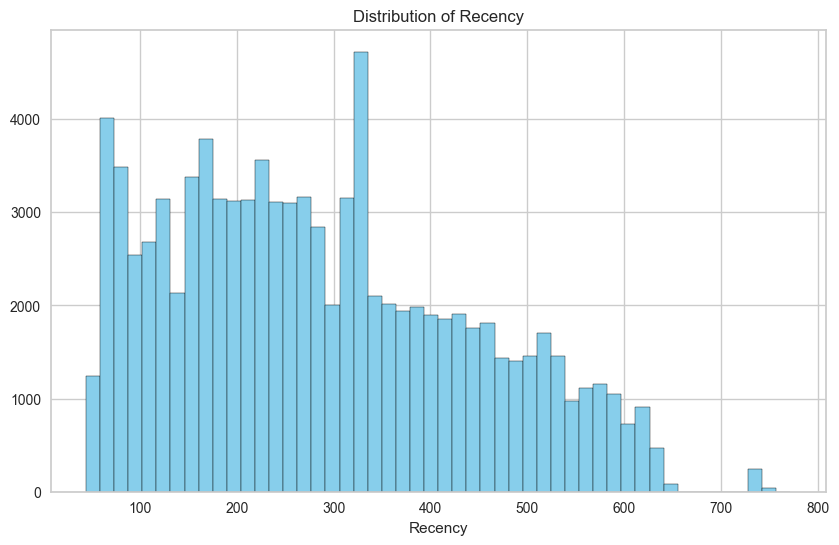

In [4]:
plt.figure(figsize=(10, 6))
plt.hist(customer_agg_r['Recency'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Recency')
plt.xlabel('Recency')
plt.show()

To validate cluster consistency, we calculate the silhouette score to determine the optimal number of clusters.

In [5]:
customer_recency = customer_agg_r[['Recency']]
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000)
    kmeans.fit(customer_recency)
    cluster = kmeans.predict(customer_recency)
    silhouette_avg = silhouette_score(customer_recency, cluster)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)



For n_clusters = 2 The average silhouette_score is : 0.5979511286310562
For n_clusters = 3 The average silhouette_score is : 0.5779837935252317
For n_clusters = 4 The average silhouette_score is : 0.5516119180125003
For n_clusters = 5 The average silhouette_score is : 0.5594744364773283
For n_clusters = 6 The average silhouette_score is : 0.55152391554954
For n_clusters = 7 The average silhouette_score is : 0.5419622285852782
For n_clusters = 8 The average silhouette_score is : 0.551433655047126
For n_clusters = 9 The average silhouette_score is : 0.5547635663559449


Here it looks like 2 is the optimal one. Based on business requirements, we can go ahead with less or more clusters. We will be selecting 3 for this example:

In [6]:
customer_recency = customer_agg_r[['Recency']]
kmeans = KMeans(n_clusters=3, random_state=618)
kmeans.fit(customer_recency)
customer_agg_rfm['RecencyCluster'] = kmeans.predict(customer_recency)

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

customer_recency = order_cluster('RecencyCluster', 'Recency',customer_agg_rfm,False)


In [7]:
customer_recency.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,21542.0,508.328150,68.807237,408.0,450.0,501.0,559.0,772.0
1,34961.0,305.467092,51.784427,222.0,260.0,308.0,343.0,407.0
2,36419.0,136.478212,50.077866,44.0,89.0,137.0,180.0,221.0


As cluster numbers decrease from 2 to 0, recency increases.

### Frequency

We will apply same clustering method to frequency. 

In [9]:
customer_agg_f = customer_agg_rfm[['customer_unique_id', 'Frequency']]
customer_agg_f.head()

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


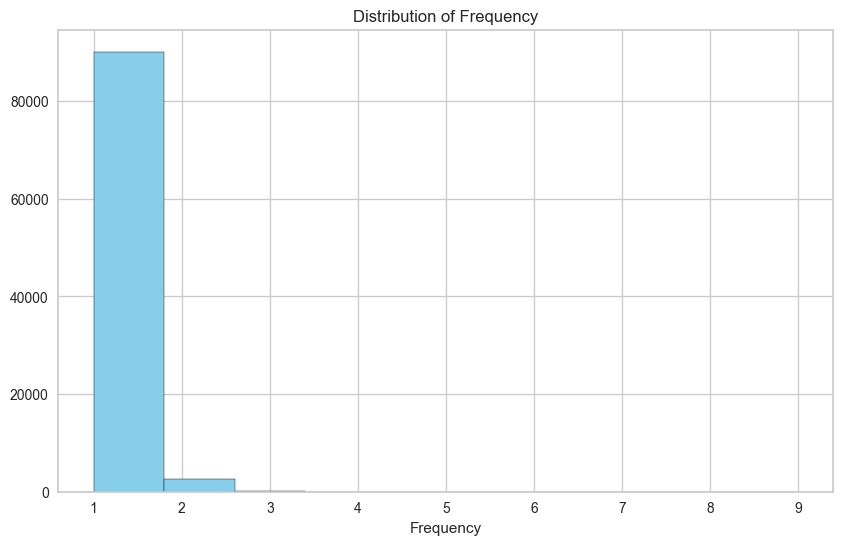

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(customer_agg_f['Frequency'], color='skyblue', edgecolor='black')
plt.title('Distribution of Frequency')
plt.xlabel('Frequency')
plt.show()

From the histogram, it is evident that the majority of customers made only a single purchase.

In [11]:
customer_agg_f['Frequency'].value_counts()

Frequency
1    90117
2     2583
3      181
4       28
5        6
6        3
7        3
9        1
Name: count, dtype: int64

In [12]:
customer_frequency = customer_agg_f[['Frequency']]
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000)
    kmeans.fit(customer_frequency)
    cluster = kmeans.predict(customer_frequency)
    silhouette_avg = silhouette_score(customer_frequency, cluster)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)



For n_clusters = 2 The average silhouette_score is : 0.9959143019910768
For n_clusters = 3 The average silhouette_score is : 0.9991738819194673
For n_clusters = 4 The average silhouette_score is : 0.9997243431767148
For n_clusters = 5 The average silhouette_score is : 0.9998829013745711
For n_clusters = 6 The average silhouette_score is : 0.9998776183760678
For n_clusters = 7 The average silhouette_score is : 0.999940810572308
For n_clusters = 8 The average silhouette_score is : 0.9999892382858742
For n_clusters = 9 The average silhouette_score is : 0.9999892382858742


We will choose k = 3.

In [13]:
customer_frequency = customer_agg_f[['Frequency']]

kmeans = KMeans(n_clusters=3, random_state= 618)
kmeans.fit(customer_frequency)
customer_agg_rfm['FrequencyCluster'] = kmeans.predict(customer_frequency)


customer_frequency = order_cluster('FrequencyCluster', 'Frequency',customer_agg_rfm,True)

In [14]:
customer_frequency.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,90117.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,2583.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
2,222.0,3.301802,0.803779,3.0,3.0,3.0,3.0,9.0


As cluster numbers decrease from 2 to 0, frequency increases.

### Monetary

We will apply same clustering method to monetary. 

In [15]:
customer_agg_m = customer_agg_rfm[['customer_unique_id', 'Monetary']]
customer_agg_m.head()

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


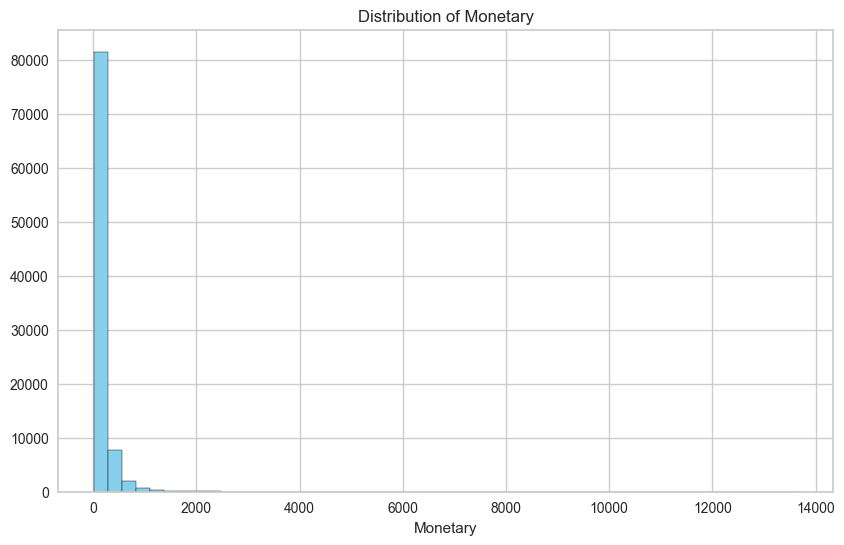

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(customer_agg_m['Monetary'],bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Monetary')
plt.xlabel('Monetary')
plt.show()

In [17]:
customer_agg_m['Monetary'].min(), customer_agg_m['Monetary'].max()

(9.59, 13664.08)

The range of Monetary values extends from 9.59 to 13664.08, which is quite substantial.

In [18]:
customer_monetary = customer_agg_m[['Monetary']]
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000)
    kmeans.fit(customer_monetary)
    cluster = kmeans.predict(customer_monetary)
    silhouette_avg = silhouette_score(customer_monetary, cluster)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)



For n_clusters = 2 The average silhouette_score is : 0.8564679756449658
For n_clusters = 3 The average silhouette_score is : 0.7510380222316281
For n_clusters = 4 The average silhouette_score is : 0.6633465459138262
For n_clusters = 5 The average silhouette_score is : 0.6391561108688881
For n_clusters = 6 The average silhouette_score is : 0.6071155715590132
For n_clusters = 7 The average silhouette_score is : 0.6038896855801742
For n_clusters = 8 The average silhouette_score is : 0.6008690166574147
For n_clusters = 9 The average silhouette_score is : 0.5775992461134888


We will choose k = 3.

In [19]:
kmeans = KMeans(n_clusters=3, random_state= 618)
kmeans.fit(customer_monetary)
customer_agg_rfm['MonetaryCluster'] = kmeans.predict(customer_monetary)

customer_monetary = order_cluster('MonetaryCluster', 'Monetary',customer_agg_rfm,True)


In [20]:
customer_monetary.groupby('MonetaryCluster')['Monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
MonetaryCluster,,,,,,,,
0,82653.0,111.334818,65.583722,9.59,58.6200,96.490,152.3800,303.12
1,9343.0,494.553525,188.441480,303.17,349.6900,420.960,597.7950,1104.93
2,926.0,1718.220486,812.799528,1107.96,1256.2725,1476.435,1934.7875,13664.08


As cluster numbers decrease from 2 to 0, monetary increases.

### Overall Score

In [21]:
customer_agg_rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,RecencyCluster,FrequencyCluster,MonetaryCluster
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,1,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,1,0,0
2,0000f46a3911fa3c0805444483337064,585,1,86.22,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62,2,0,0
4,0004aac84e0df4da2b147fca70cf8255,336,1,196.89,2,0,0


In [22]:
customer_agg_rfm['OverallScore'] = customer_agg_rfm['RecencyCluster'] + customer_agg_rfm['FrequencyCluster'] + customer_agg_rfm['MonetaryCluster']


In [23]:
customer_agg_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92922 entries, 0 to 92921
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  92922 non-null  object 
 1   Recency             92922 non-null  int64  
 2   Frequency           92922 non-null  int64  
 3   Monetary            92922 non-null  float64
 4   RecencyCluster      92922 non-null  int32  
 5   FrequencyCluster    92922 non-null  int32  
 6   MonetaryCluster     92922 non-null  int32  
 7   OverallScore        92922 non-null  int32  
dtypes: float64(1), int32(4), int64(2), object(1)
memory usage: 4.3+ MB


In [24]:
rfm_df = customer_agg_rfm.groupby('OverallScore')[['Recency','Frequency','Monetary']].mean()
rfm_df

,Recency,Frequency,Monetary
OverallScore,,,
0,507.800000,1.000000,108.487940
1,162.310158,1.010476,134.305228
2,287.945379,1.025775,159.709874
3,281.006041,1.247249,543.342591
4,284.357675,1.786885,972.342310
5,286.722222,2.972222,1035.423750
6,319.000000,4.125000,1555.032500


In [25]:
customer_agg_rfm.groupby('OverallScore')[['RecencyCluster','FrequencyCluster','MonetaryCluster']].mean()

,RecencyCluster,FrequencyCluster,MonetaryCluster
OverallScore,,,
0,0.000000,0.000000,0.000000
1,0.931122,0.010476,0.058402
2,1.862486,0.025631,0.111883
3,1.832794,0.247033,0.920173
4,1.870343,0.742176,1.387481
5,1.861111,1.666667,1.472222
6,2.000000,2.000000,2.000000


The scoring above clearly shows us that customers with score 5 is our best customers whereas 0 is the worst.

### Explore each cluster‘s customer 

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm_df)

rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm_df.columns)
rfm_scaled_df

,Recency,Frequency,Monetary
0,1.000000,0.000000,0.000000
1,0.000000,0.003352,0.017848
2,0.363644,0.008248,0.035410
3,0.343558,0.079120,0.300616
4,0.353259,0.251803,0.597185
5,0.360103,0.631111,0.640793
6,0.453530,1.000000,1.000000


Radar plots are particularly useful when we need to compare multiple quantitative variables in a way that reveals patterns or differences in their distribution across various categories or entities. Each axis on a radar plot represents a different variable, and the values for each cluster are plotted along these axes. 

In [27]:
rfm_scaled = rfm_scaled.tolist()

rfm_scaled

[[1.0, 0.0, 0.0],
 [0.0, 0.0033524169273446147, 0.01784755776945625],
 [0.3636437482799906, 0.008247990815154982, 0.03540985565436061],
 [0.3435582434965633, 0.0791197411003236, 0.30061614638840795],
 [0.3532593510484321, 0.25180327868852465, 0.5971847628496683],
 [0.3601033933911403, 0.6311111111111112, 0.6407931256723507],
 [0.45352952005338776, 1.0, 1.0]]

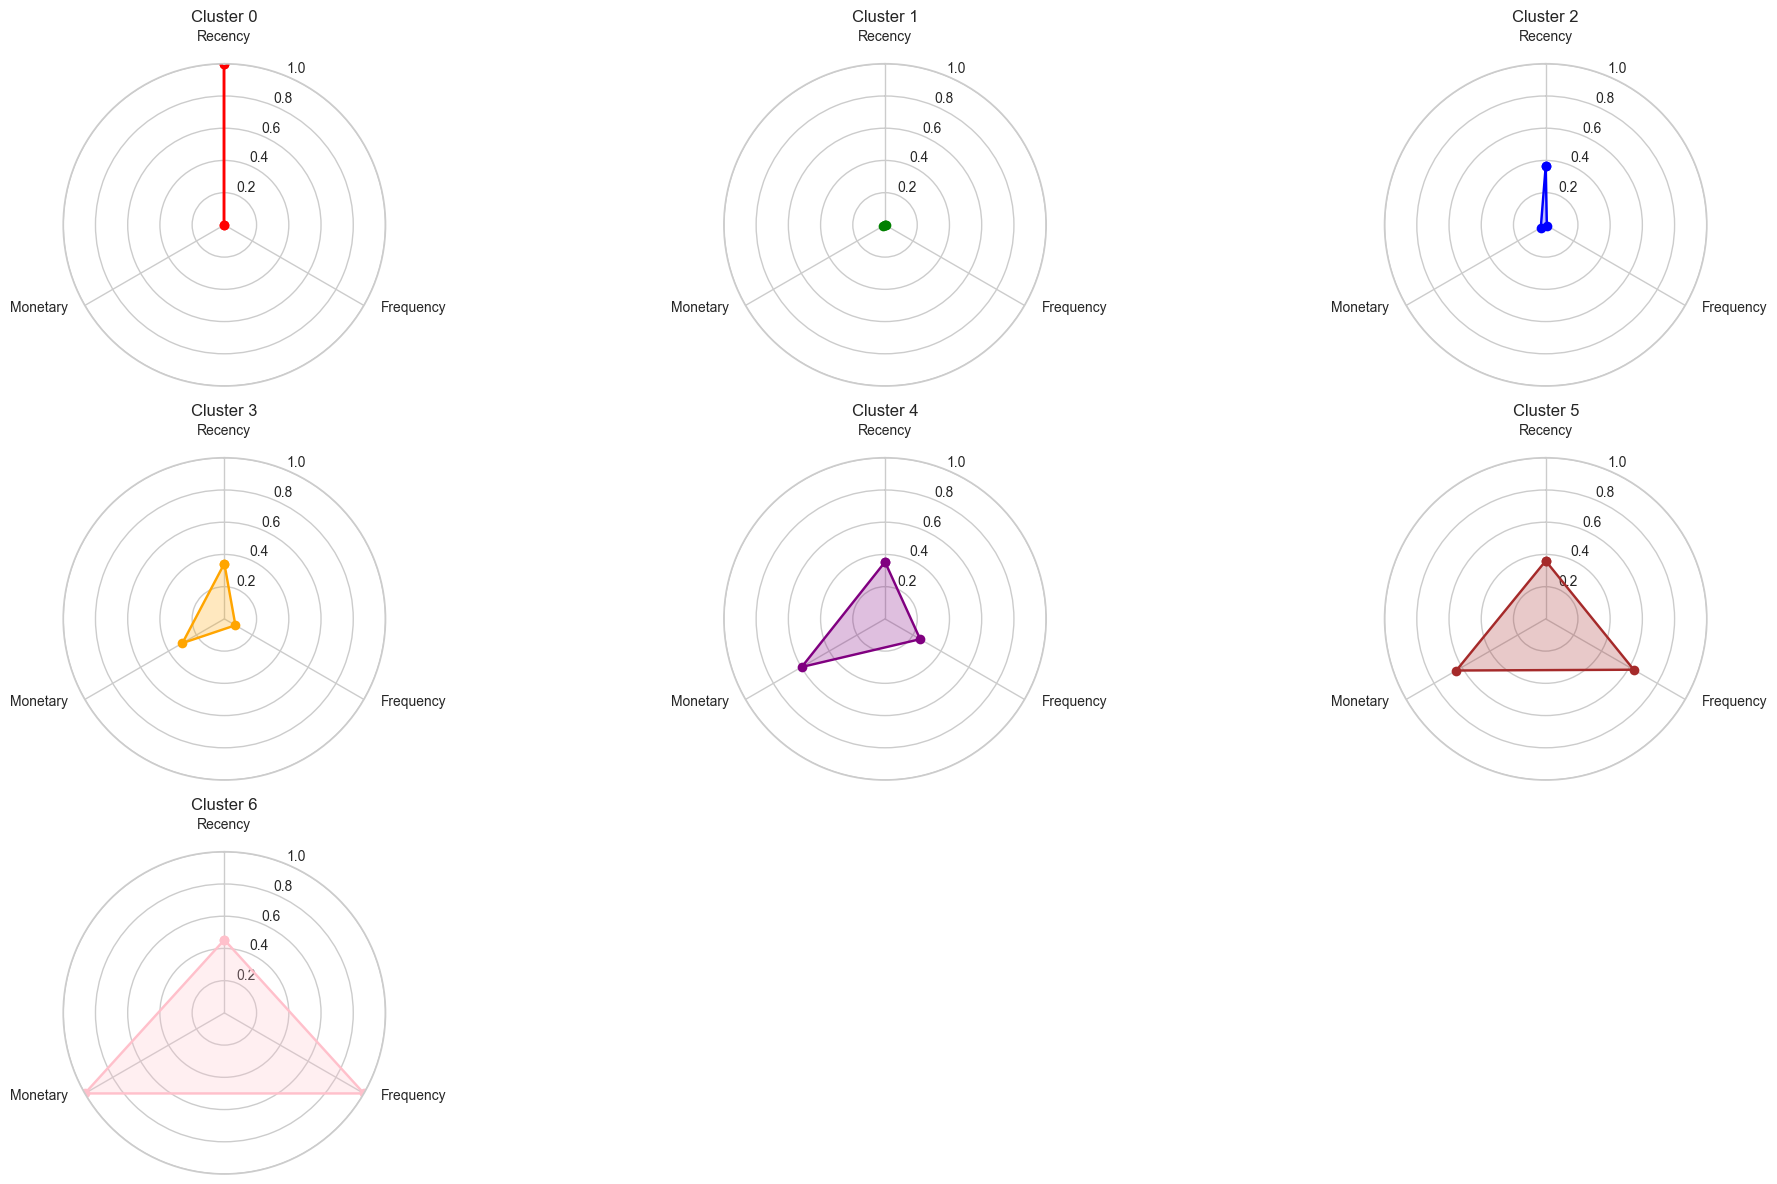

In [28]:
def make_radar_chart(ax, stats, attribute_labels, plot_str='-', color='b'):
    angles = np.linspace(0, 2 * np.pi, len(attribute_labels), endpoint=False).tolist()
    stats = np.concatenate((stats, [stats[0]]))  # Close the loop
    angles += angles[:1]  # Close the loop
    
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    ax.fill(angles, stats, alpha=0.25, color=color)
    ax.plot(angles, stats, plot_str, marker='o', color=color)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(attribute_labels)

    # Setting the range for each axis
    ax.set_ylim(0, 1)  # This sets the radial limits from 0 to 1

    # Adjust the location and direction of labels
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')

        label.set_verticalalignment('bottom')
        label.set_rotation(np.degrees(angle))
        label.set_rotation_mode('anchor')


# Example of creating the radar charts
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 12), subplot_kw=dict(polar=True))
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink']

# Assuming rfm_scaled is a list of scaled data arrays, each corresponding to a cluster
for i, ax in enumerate(axs.flatten()):
    if i < len(rfm_scaled):
        make_radar_chart(ax, rfm_scaled[i], rfm_df.columns, color=colors[i % len(colors)])
        ax.set_title(f'Cluster {i}')
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.show()


In [29]:
rfm_df.columns

Index(['Recency', 'Frequency', 'Monetary'], dtype='object')

- **Cluster 0**: Has a very high Recency but low Frequency and Monetary values. This might indicate customers who have made a purchase very recently but do not purchase often and spend little when they do. These customer are considered **New customers**.

- **Cluster 1**: Scores are near zero for all three dimensions. This group likely represents dormant customers with very low engagement and spending. These customer are considered **Lost customers**.

- **Cluster 2**: Has moderate Recency, very low Frequency, and low Monetary values. This suggests customers who have engaged somewhat recently but with infrequent purchases and low spending. These customer are considered **Lost customers**.

- **Cluster 3**: Shows low Recency and Frequency, and very low Monetary values. These customers may engage at moderate intervals but haven't done so recently and tend to spend very little. These customer are considered **New customers**.

- **Cluster 4**: Exhibits moderate values across Recency, Frequency, and Monetary dimensions. Customers in this cluster have an average level of recent engagement, purchase frequency, and spending. These customer are considered **Importantly cultivate customers**.

- **Cluster 5**: Shows low to moderate Recency and Frequency, with a slightly higher Monetary value. This suggests customers who spend reasonably well when they purchase, though they do so infrequently and haven't made purchases recently. These customer are considered **Important value customers**.

- **Cluster 6**: Represents customers with moderate Recency but higher Monetary and Frequency values. This suggests customers who spend reasonably well when they purchase, though they do so infrequently and haven't made purchases recently.These customer are considered **Important value customers**.

To keep things simple, better we name these scores:

- 0, 3 : New customers
- 1, 2: Lost customers
- 4 : Importantly cultivate customers
- 5, 6: Important value customers

In [30]:
customer_agg_rfm['Segment'] = 'Important value customers'
customer_agg_rfm.loc[customer_agg_rfm['OverallScore']<5,'Segment'] = 'Importantly cultivate customers' 
customer_agg_rfm.loc[customer_agg_rfm['OverallScore']==3,'Segment'] = 'New customers' 
customer_agg_rfm.loc[customer_agg_rfm['OverallScore']==0,'Segment'] = 'New customers' 
customer_agg_rfm.loc[customer_agg_rfm['OverallScore']==1,'Segment'] = 'Lost customers' 
customer_agg_rfm.loc[customer_agg_rfm['OverallScore']==2,'Segment'] = 'Lost customers' 

Examine the distribution of our segments on a scatter plot:

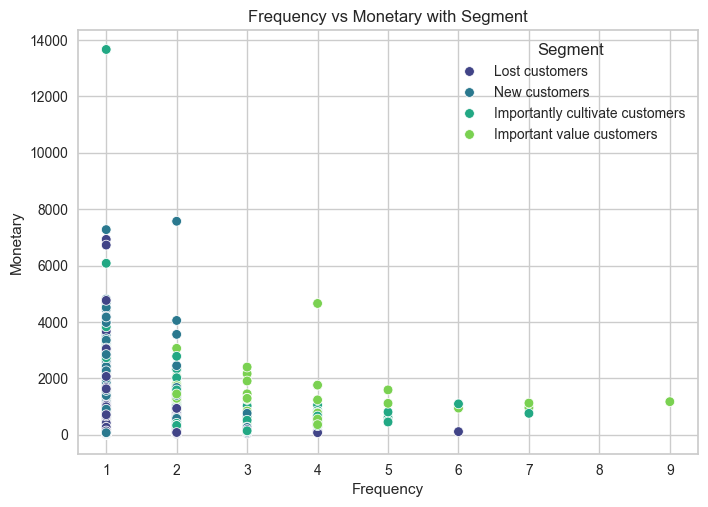

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Recency vs Frequency with segment
sns.scatterplot(data=customer_agg_rfm, x='Frequency', y='Monetary', hue='Segment', palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Frequency vs Monetary with Segment')
plt.show()


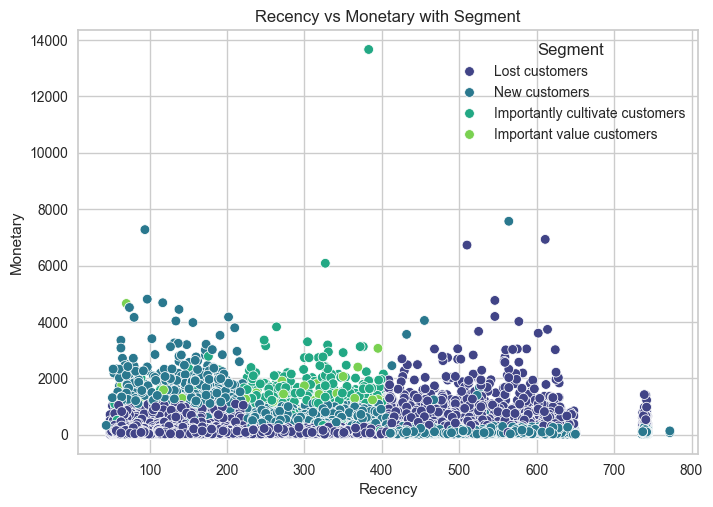

In [32]:
# Plot Recency vs  with segment
sns.scatterplot(data=customer_agg_rfm, x='Recency', y='Monetary', hue='Segment', palette='viridis')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.title('Recency vs Monetary with Segment')
plt.show()


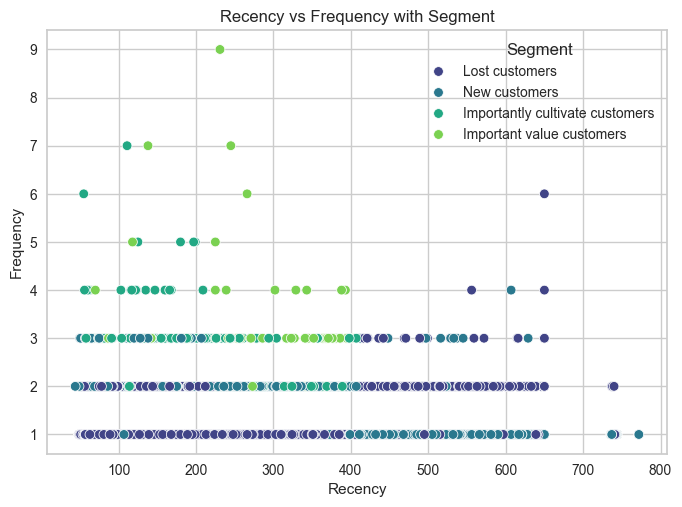

In [33]:
# Plot Recency vs  with segment
sns.scatterplot(data=customer_agg_rfm, x='Recency', y='Frequency', hue='Segment', palette='viridis')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Recency vs Frequency with Segment')
plt.show()

We can start taking actions with this segmentation. The main strategies are quite clear:

- **Cluster 0, 3**: New customers
  - Use welcome emails, product tutorials, and first-time buyer offers to enhance their initial experience. Encourage product discovery and second purchases with targeted follow-up campaigns. Collect data on their preferences for future personalization.

- **Cluster 1, 2**: Lost customers
  - Implement re-engagement campaigns that may include special offers, reminders of the brand’s value, and feedback requests to understand their inactivity. Analyze their previous interactions to tailor the re-engagement approach.

- **Cluster 4**: Importantly cultivate customers
  - Develop loyalty programs that reward continued patronage, and consider exclusive content or events to build a community feeling. Provide personalized recommendations based on past purchases. Invest in upselling and cross-selling strategies to increase their purchase frequency and monetary value.

- **Cluster 5, 6**: Important value customers
  - Deliver VIP treatment with exclusive deals and early access to new products or sales. Leverage their high monetary value with personalized high-end offers and premium customer service. Implement referral programs to convert their satisfaction into new customer leads. Use their purchase history to anticipate needs and provide relevant upsells.




In [34]:
customer_agg_rfm.to_csv('Generated_Dataset/customer_rfm_model.csv', index=False)

After RFM Modeling, we further examined the customer segmentation based on all useful features derived in our data.

# Preprocessing 


In this part, we processed our data for better clustering. Meaningful clustering based on all features (not only R,F and M) is much harder than traditional RFM Modeling, since clustering methods can be impacted by data skewness, scales and dimensionality.

## Skewness - Transformation

Skewness in the features of a dataset significantly impacts clustering algorithms like K-means, since it uses distance measurements to determine the similarity between data points. Therefore, I tried to transfom the skewed features to be more normal.

In [135]:
customer_agg['Recency_log'] = np.log(customer_agg['Recency'])
customer_agg['Frequency_log'] = np.log(customer_agg['Frequency'])
customer_agg['Monetary_log'] = np.log(customer_agg['Monetary'])
customer_agg['average_payment_value_log'] = np.log(customer_agg['average_payment_value'])


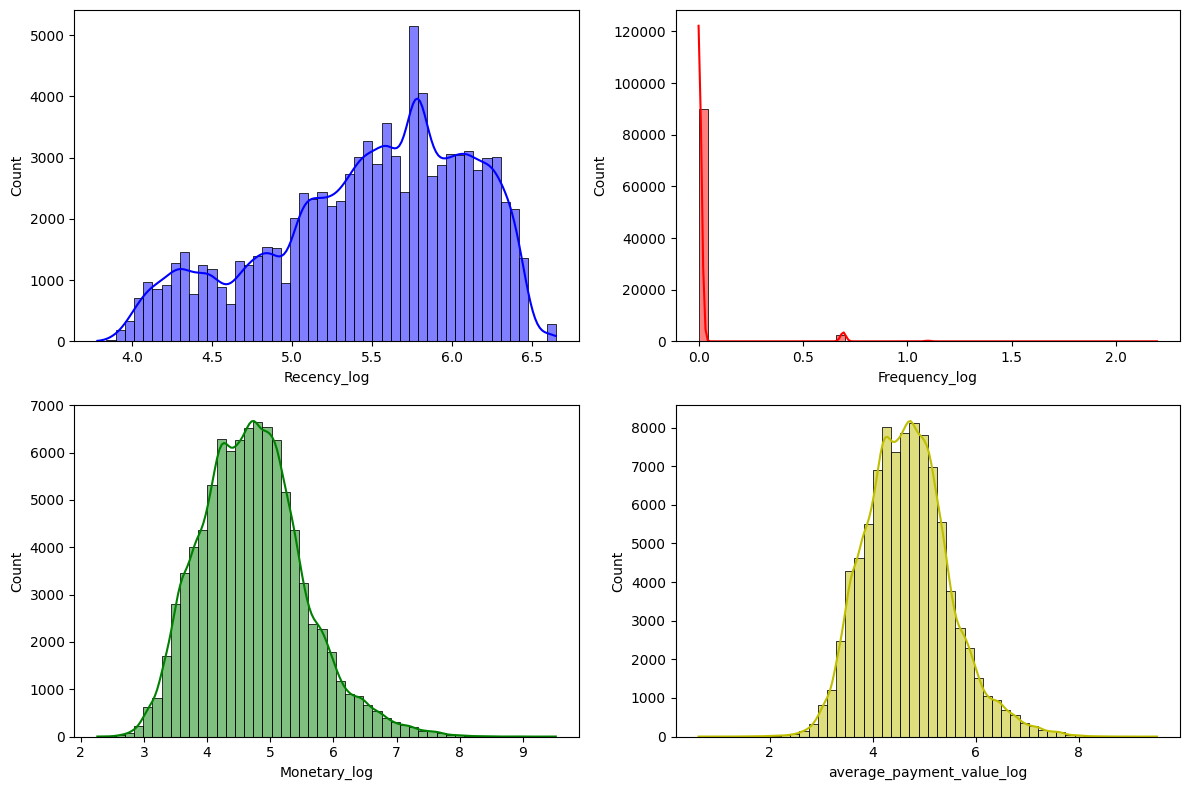

In [138]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
sns.histplot(customer_agg['Recency_log'], color='b', bins=50, kde=True)

plt.subplot(2,2,2)
sns.histplot(customer_agg['Frequency_log'], color='r', bins=50, kde=True)

plt.subplot(2,2,3)
sns.histplot(customer_agg['Monetary_log'], color='g', bins=50, kde=True)

plt.subplot(2,2,4)
sns.histplot(customer_agg['average_payment_value_log'], color='y', bins=50, kde=True)

plt.tight_layout()
plt.show()


Frequency still does not look normal. Need to consider if it should be taken into clustering. Recency and Monetary looks okay after transformation. 

## Outlier Detection

Outliers can potentially skew the results of our analysis, especially in kmeans clustering where they can significantly influence the position of the cluster centroids. Therefore, it is essential to identify and treat these outliers appropriately to achieve more accurate and meaningful clustering results.  

Since there are a lot of features in data, it would be more prudent to use machine learning algorithms to detect outliers in multi-dimensional spaces, compared with the IQR method where we can only detect outliers for each one of the features. 

Isolation Forest works well for outlier detection in multi-dimensional data and is computationally efficient. It isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature, and outliers are marked if the branch of that datapoint is too short. However, the hyperparameter `contamination` need to be initialized based on prior knowledge of the data, specifically the proportion of outliers in data, which is kind of hard for our data. 

Therefore, I decided to first try IQR method on some insightful features, and use this information to aid in initializing the `contamination` hyperparameter in IsolationForest model. 

In [105]:
customer_agg.head()

,customer_unique_id,avg_review_score,order_counts,review_score_counts,review_comment_counts,rating_rate,comment_rate,n_payment_types,average_payment_value,boleto,credit_card,debit_card,voucher,Beauty & Fashion,Electronics,Home & Living,Leisure & Entertainment,Tools,order_purchase_timestamp,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,1,1,1,1.0,1.0,1,141.90,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2018-05-10 10:56:27,160,1,141.90,5.075174,0.0,4.955123
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,1,1,0,1.0,0.0,1,27.19,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2018-05-07 11:11:27,163,1,27.19,5.093750,0.0,3.302849
2,0000f46a3911fa3c0805444483337064,3.0,1,1,0,1.0,0.0,1,86.22,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2017-03-10 21:05:03,585,1,86.22,6.371612,0.0,4.456902
3,0000f6ccb0745a6a4b88665a16c9f078,4.0,1,1,1,1.0,1.0,1,43.62,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017-10-12 20:29:41,369,1,43.62,5.910797,0.0,3.775516
4,0004aac84e0df4da2b147fca70cf8255,5.0,1,1,0,1.0,0.0,1,196.89,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017-11-14 19:45:42,336,1,196.89,5.817111,0.0,5.282645


In [141]:
outlier_detect_cols = ['average_payment_value_log', 'Recency_log', 'Frequency_log', 'Monetary_log']

### IQR

I only selected 4 continuous numerical value for IQR outlier detection, since other numerical features are discrete and also do not have a large range, which means it's hard to detect the outliers using statistical methods.

In [143]:
# Calculate the IQR for each feature
Q1 = customer_agg[outlier_detect_cols].quantile(0.25)
Q3 = customer_agg[outlier_detect_cols].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers for each feature
outliers = {}
for column in outlier_detect_cols:
    outliers[column] = customer_agg[(customer_agg[column] < lower_bound[column]) | (customer_agg[column] > upper_bound[column])]

# Print the outliers for each feature
for column, outlier_df in outliers.items():
    print(f"{outlier_df.shape[0]} outliers for {column}")


1565 outliers for average_payment_value_log
0 outliers for Recency_log
2805 outliers for Frequency_log
1387 outliers for Monetary_log


In [144]:
customer_agg.shape

(92922, 28)

~ 2000 outliers from ~90000 datapoints, outlier proportion nearly 0.02

### Isolation Forest

Based on the IQR information, we can initialize the Isolation Forest with contamination=0.02, which means we set the threshold for outlier detection with an approximately 2% proportion of outliers in data.

In [145]:
# Using Isolation Forest to detect outliers
model = IsolationForest(contamination=0.02, random_state=42)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_agg['Outlier_Scores'] = model.fit_predict(customer_agg[outlier_detect_cols].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_agg['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_agg['Outlier_Scores']]

In [146]:
customer_agg[customer_agg.Is_Outlier==1]

,customer_unique_id,avg_review_score,order_counts,review_score_counts,review_comment_counts,rating_rate,comment_rate,n_payment_types,average_payment_value,boleto,credit_card,debit_card,voucher,Beauty & Fashion,Electronics,Home & Living,Leisure & Entertainment,Tools,order_purchase_timestamp,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log,Outlier_Scores,Is_Outlier,average_payment_value_log
120,004b45ec5c64187465168251cd1c9c2f,3.000000,2,2,2,1.0,1.000000,1,73.860000,1.0,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.0,2018-05-26 19:42:48,143,2,147.72,4.962845,0.693147,4.995319,-1,1,4.302171
254,00adeda9b742746c0c66e10d00ea1b74,1.000000,1,1,1,1.0,1.000000,1,2148.400000,0.0,1.000000,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.0,2017-11-07 16:54:04,344,1,2148.40,5.840642,0.000000,7.672479,-1,1,7.672479
287,00c07da5ba0e07b4f248a3a373b07476,5.000000,1,1,0,1.0,0.000000,1,2304.680000,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.0,2018-07-27 14:28:20,82,1,2304.68,4.406719,0.000000,7.742697,-1,1,7.742697
416,011875f0176909c5cf0b14a9138bb691,5.000000,1,1,0,1.0,0.000000,1,4016.910000,0.0,1.000000,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.0,2017-03-18 20:08:04,577,1,4016.91,6.357842,0.000000,8.298268,-1,1,8.298268
428,012452d40dafae4df401bced74cdb490,4.500000,2,2,1,1.0,0.500000,2,165.110000,0.0,0.666667,0.0,0.333333,0.500000,0.0,0.500000,0.0,0.0,2018-05-14 12:12:45,156,2,495.33,5.049856,0.693147,6.205224,-1,1,5.106612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93455,ff922bdd6bafcdf99cb90d7f39cea5b3,4.333333,3,3,1,1.0,0.333333,1,46.533333,0.0,1.000000,0.0,0.000000,0.333333,0.0,0.666667,0.0,0.0,2017-09-14 14:24:04,398,3,139.60,5.986452,1.098612,4.938781,-1,1,3.840169
93514,ffba9f9dff87b05e310ecc46c8591044,5.000000,1,1,1,1.0,1.000000,1,1626.830000,0.0,1.000000,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.0,2017-02-27 15:39:41,597,1,1626.83,6.391917,0.000000,7.394389,-1,1,7.394389
93566,ffe254cc039740e17dd15a5305035928,3.000000,2,2,2,1.0,1.000000,1,40.060000,0.0,1.000000,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.0,2017-04-02 16:33:30,563,2,80.12,6.333280,0.693147,4.383526,-1,1,3.690378
93599,fff5eb4918b2bf4b2da476788d42051c,5.000000,1,1,1,1.0,1.000000,1,2844.960000,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.0,2018-07-02 16:39:59,107,1,2844.96,4.672829,0.000000,7.953304,-1,1,7.953304


In [147]:
# keep the outliers for further analysis
outliers = customer_agg[customer_agg.Is_Outlier==1]

haven't remove outliers by now

## Scaling

It's imperative to scale our features before we jump to clustering, and also PCA. For clustering, since it is conducted based on the distance measurements, features in large scale would disproportionately influence the clustering outcome, potentially leading to incorrect groupings. For PCA, features in large scale would dominate the eigendecomposition,  not accurately reflecting the underlying principal components in the data.  

Since the discrete numerical features do not have a large range, we did not scale them.  
For the Frequency data, since the log of it does not work well in terms of correcting skewness, and also the value is not very large, I did not scale it.

In [143]:
# customer_agg = pd.read_csv('Generated_Dataset/customer_agg_4cluster_proc.csv')

In [144]:
scale_cols = ['average_payment_value_log', 'Recency_log', 'Monetary_log']

In [145]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Copy the cleaned dataset
customer_scaled = customer_agg.copy()

# Applying the scaler to the necessary columns in the dataset
customer_scaled[scale_cols] = scaler.fit_transform(customer_agg[scale_cols])

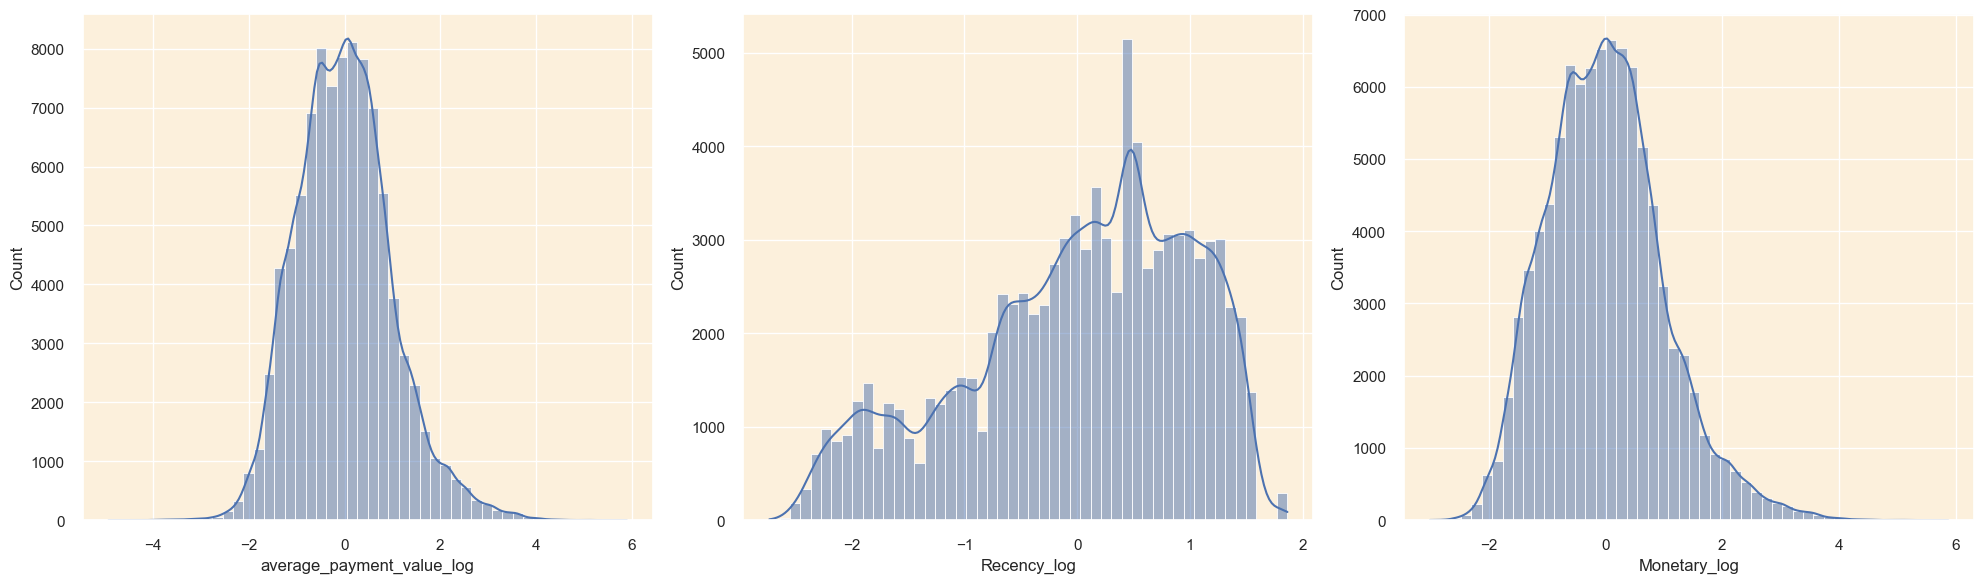

In [146]:
plt.figure(figsize=(20,6))
for i in range(len(scale_cols)):
    plt.subplot(1,3,i+1)
    col = scale_cols[i]
    sns.histplot(customer_scaled[col], bins=50, kde=True)

plt.tight_layout()
plt.show()
    


## Dimension Reduction

Dimension Reduction is helpful in improving clustering performance, in that it not only reduces computational cost, but also can filter noises and reduce multicolinearity.  
Since all of the features are numerical,no matter discrete or continuous, PCA can serve as a good performer in dimension reduction.

In [147]:
customer_scaled.head()

,customer_unique_id,avg_review_score,review_score_counts,review_comment_counts,rating_rate,comment_rate,n_payment_types,average_payment_value,boleto,credit_card,debit_card,voucher,Beauty & Fashion,Electronics,Home & Living,Leisure & Entertainment,Tools,order_purchase_timestamp,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log,Outlier_Scores,Is_Outlier,average_payment_value_log
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,1,1,1.0,1.0,1,141.90,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2018-05-10 10:56:27,160,1,141.90,-0.659346,0.0,0.287769,1,0,0.343176
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,1,0,1.0,0.0,1,27.19,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2018-05-07 11:11:27,163,1,27.19,-0.629555,0.0,-1.731331,1,0,-1.667195
2,0000f46a3911fa3c0805444483337064,3.0,1,0,1.0,0.0,1,86.22,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2017-03-10 21:05:03,585,1,86.22,1.419743,0.0,-0.321063,1,0,-0.263024
3,0000f6ccb0745a6a4b88665a16c9f078,4.0,1,1,1.0,1.0,1,43.62,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017-10-12 20:29:41,369,1,43.62,0.680737,0.0,-1.153726,1,0,-1.092087
4,0004aac84e0df4da2b147fca70cf8255,5.0,1,0,1.0,0.0,1,196.89,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017-11-14 19:45:42,336,1,196.89,0.530494,0.0,0.688005,1,0,0.741683


In [148]:
customer_scaled.columns

Index(['customer_unique_id', 'avg_review_score', 'review_score_counts',
       'review_comment_counts', 'rating_rate', 'comment_rate',
       'n_payment_types', 'average_payment_value', 'boleto', 'credit_card',
       'debit_card', 'voucher', 'Beauty & Fashion', 'Electronics',
       'Home & Living', 'Leisure & Entertainment', 'Tools',
       'order_purchase_timestamp', 'Recency', 'Frequency', 'Monetary',
       'Recency_log', 'Frequency_log', 'Monetary_log', 'Outlier_Scores',
       'Is_Outlier', 'average_payment_value_log'],
      dtype='object')

In [149]:
customer_scaled.set_index('customer_unique_id', inplace=True)


In [150]:
customer_scaled_selected = customer_scaled[['avg_review_score', 'rating_rate', 'comment_rate', 'n_payment_types', 
                                            'boleto', 'credit_card','debit_card', 'voucher', 
                                            'Beauty & Fashion', 'Electronics','Home & Living', 'Leisure & Entertainment', 'Tools',
                                            'Recency_log', 'Frequency', 'Monetary_log','average_payment_value_log']]

In [151]:
pca = PCA().fit(customer_scaled_selected)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

In [152]:
explained_variance_ratio

array([3.26123103e-01, 2.78347679e-01, 1.61059350e-01, 5.11275936e-02,
       4.41713733e-02, 3.65350795e-02, 3.36576471e-02, 2.93929107e-02,
       1.57329652e-02, 1.13792727e-02, 6.34546026e-03, 3.48847970e-03,
       1.94568279e-03, 6.78094866e-04, 1.53074549e-05, 4.06139455e-32,
       2.96136399e-32])

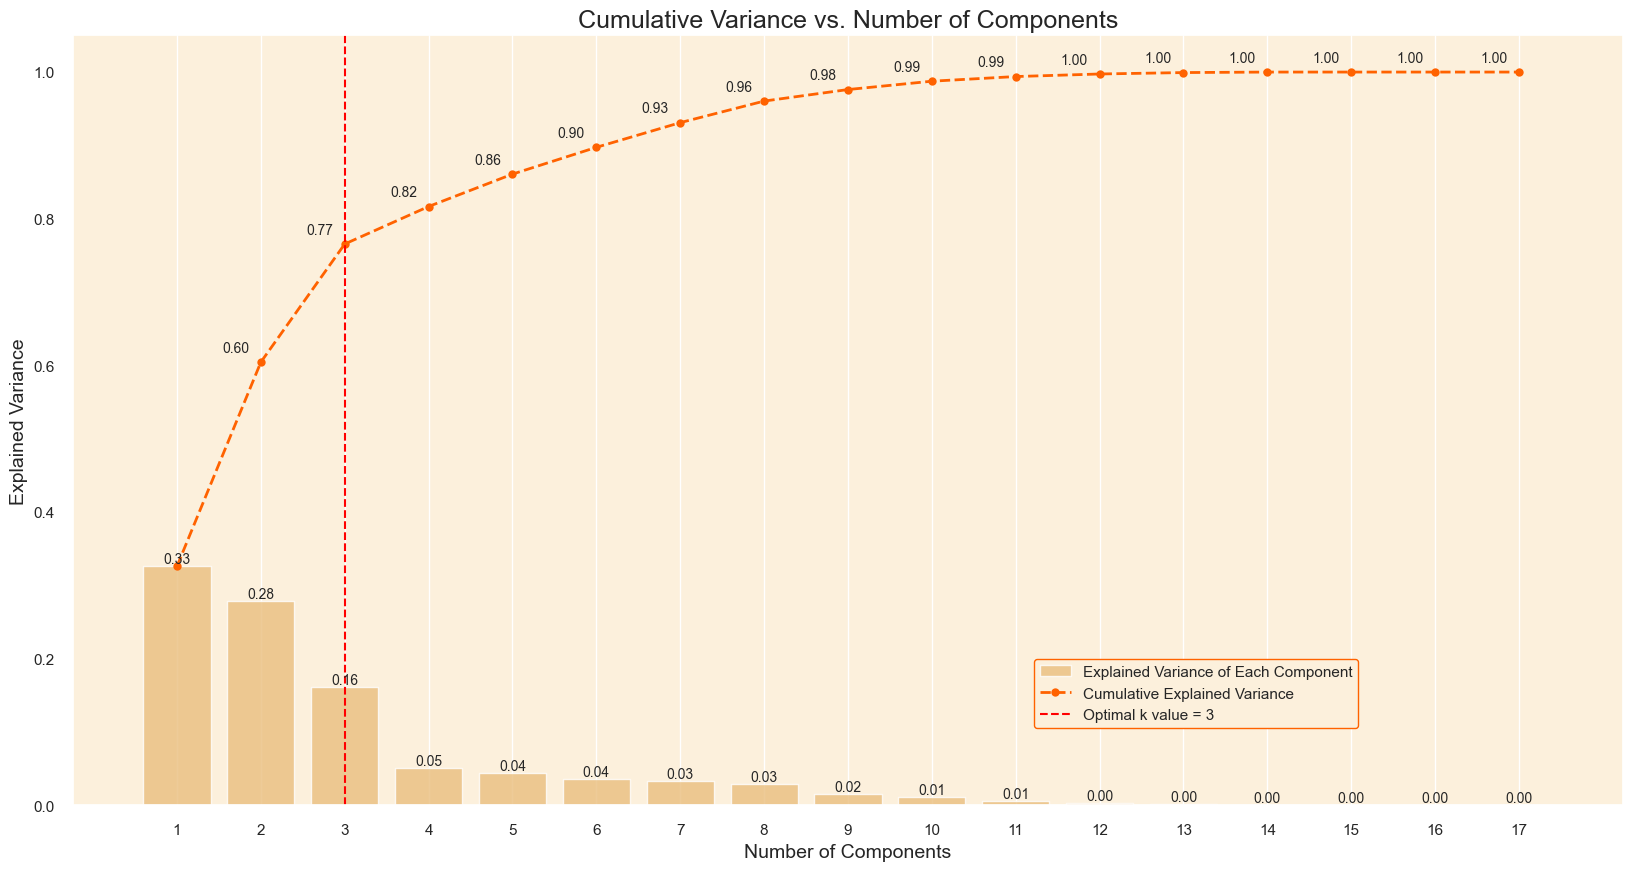

In [154]:
optimal_k = 3

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

The elbow point of the curve is Number of Components = 3, and also the first 3 components explained 77% of the variance. So I selected the first 3 components for clustering.

In [155]:
pca = PCA(n_components=3)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_scaled_selected)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_scaled_selected.index

In [156]:
customer_data_pca.head()

,PC1,PC2,PC3
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.109962,-0.986174,0.604186
0000b849f77a49e4a4ce2b2a4ca5be3f,-2.188384,0.941131,0.688110
0000f46a3911fa3c0805444483337064,0.053665,1.220612,-1.316093
0000f6ccb0745a6a4b88665a16c9f078,-1.384574,0.825731,-0.612252
0004aac84e0df4da2b147fca70cf8255,0.556544,-1.203022,-0.600886


# General Clustering

I did not use Agglomerative Clustering since our dataset is too large (~100,000) to compute efficiently. Since there are outliers, DBSCAN may perform good on clustering. So I experimented with both Kmeans and DBSCAN.

## K-means

### Select K
* silhouette score: measures the performance of clustering by **both Within Cluster Cohension and Inter Cluster Separation**.
* elbow method: determines the optimal K where the **Within Cluster Cohesion (Sum Squares)** starts to decrease slowly, like the elbow point of the arm. 

#### Silhouette Score

In [157]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        print(f'fit {k} ended')
        labels = km.predict(df)
        print(f'predict {k} ended')
        score = silhouette_score(df, labels)
        print(f'silhouette {k} ended')
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))

fit 2 ended
predict 2 ended
silhouette 2 ended
fit 3 ended
predict 3 ended
silhouette 3 ended
fit 4 ended
predict 4 ended
silhouette 4 ended
fit 5 ended
predict 5 ended
silhouette 5 ended
fit 6 ended
predict 6 ended
silhouette 6 ended
fit 7 ended
predict 7 ended
silhouette 7 ended
fit 8 ended
predict 8 ended
silhouette 8 ended
fit 9 ended
predict 9 ended
silhouette 9 ended
fit 10 ended
predict 10 ended
silhouette 10 ended


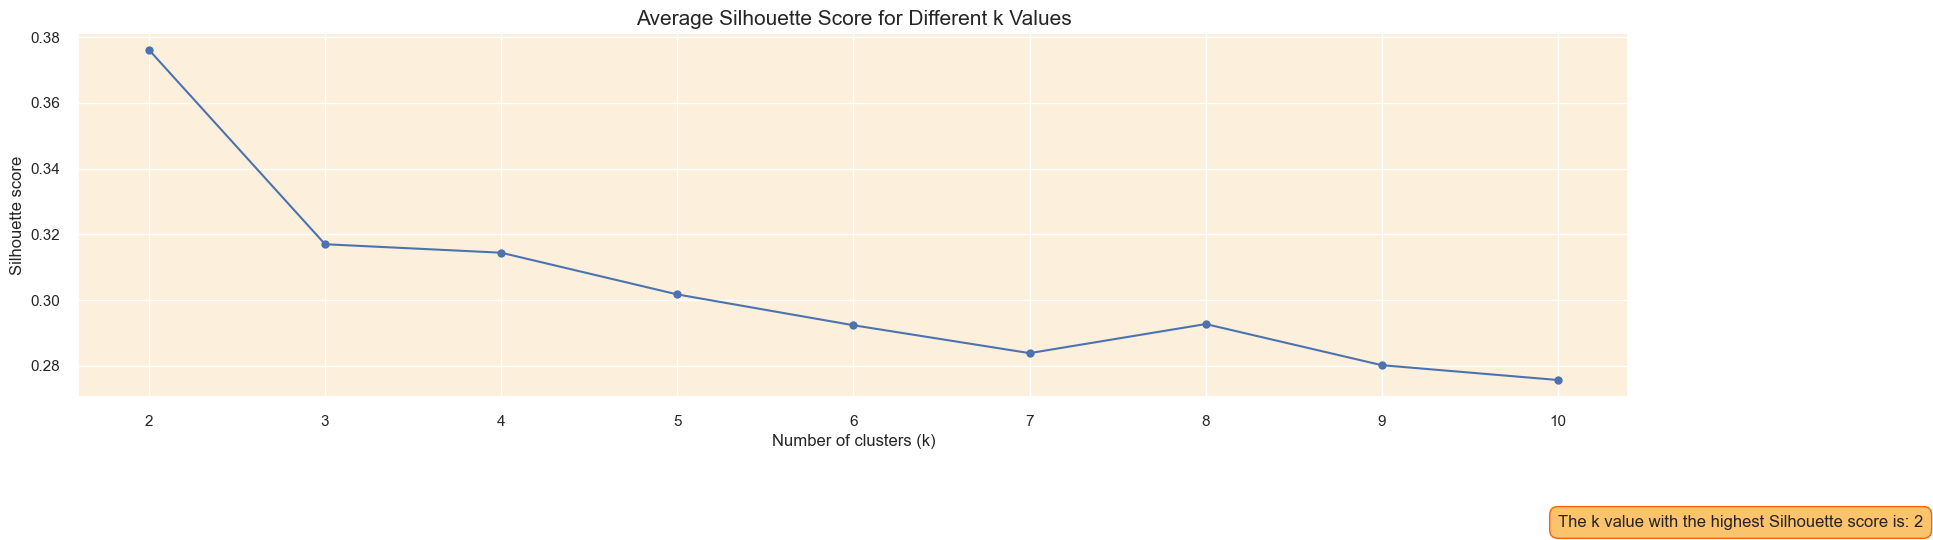

In [158]:
silhouette_analysis(customer_data_pca, 2, 10, figsize=(20, 50))

For n_clusters = 2 The average silhouette_score is : 0.3761681168733558


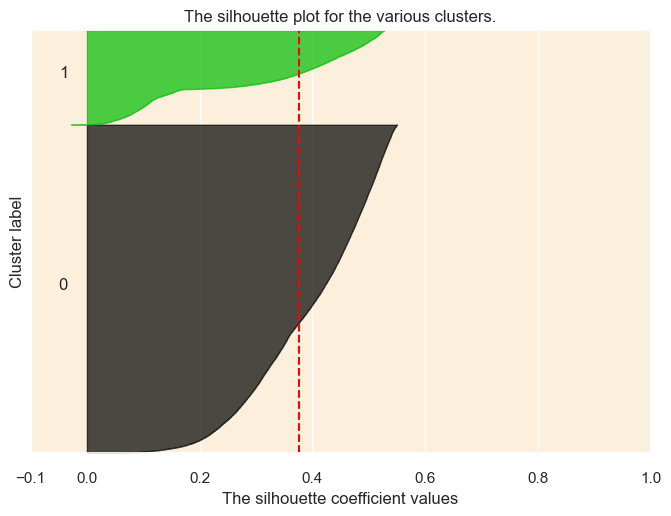

For n_clusters = 3 The average silhouette_score is : 0.316989450190434


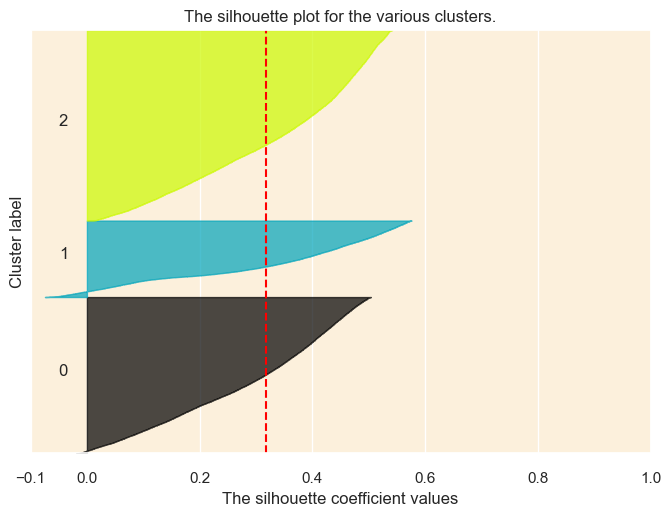

For n_clusters = 4 The average silhouette_score is : 0.31440785581351616


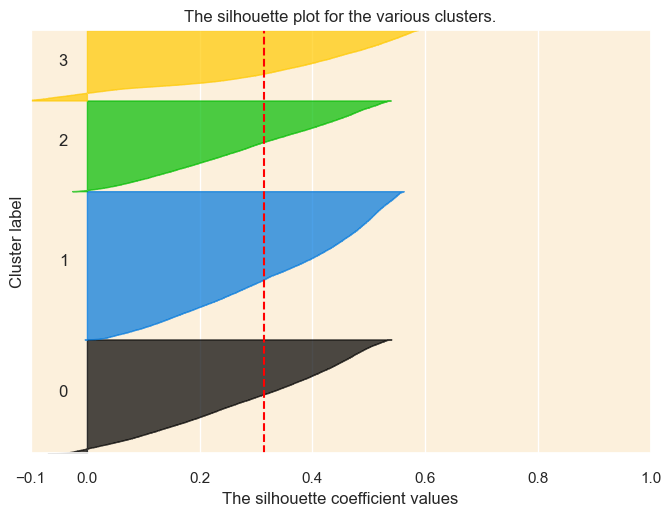

For n_clusters = 5 The average silhouette_score is : 0.3017098092318609


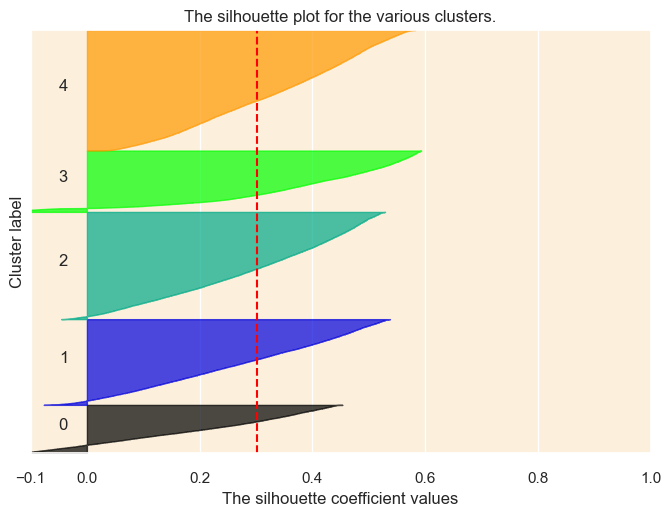

For n_clusters = 6 The average silhouette_score is : 0.2923251985667532


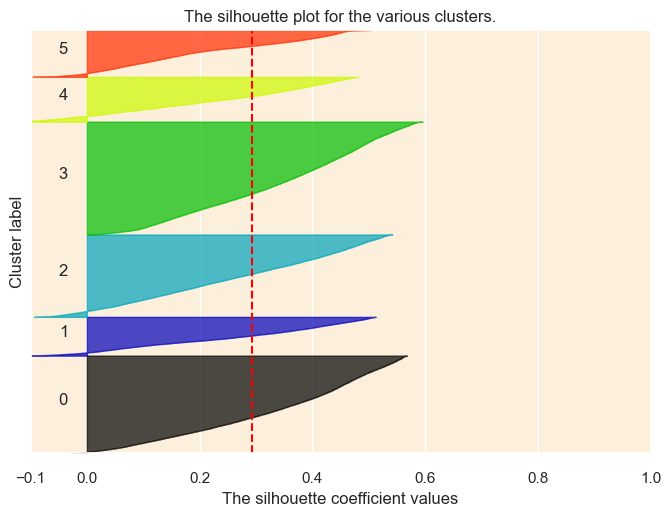

In [159]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    plt.xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(customer_data_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=100, random_state=0)
    cluster_labels = clusterer.fit_predict(customer_data_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(customer_data_pca, cluster_labels)
    print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(customer_data_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

#     # 2nd Plot showing the actual clusters formed
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
#     ax2.scatter(customer_data_pca[:, 0], customer_data_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7,
#                 c=colors, edgecolor='k')

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

#     plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
#                   "with n_clusters = %d" % n_clusters),
#                  fontsize=14, fontweight='bold')

# plt.show()

#### Elbow Method

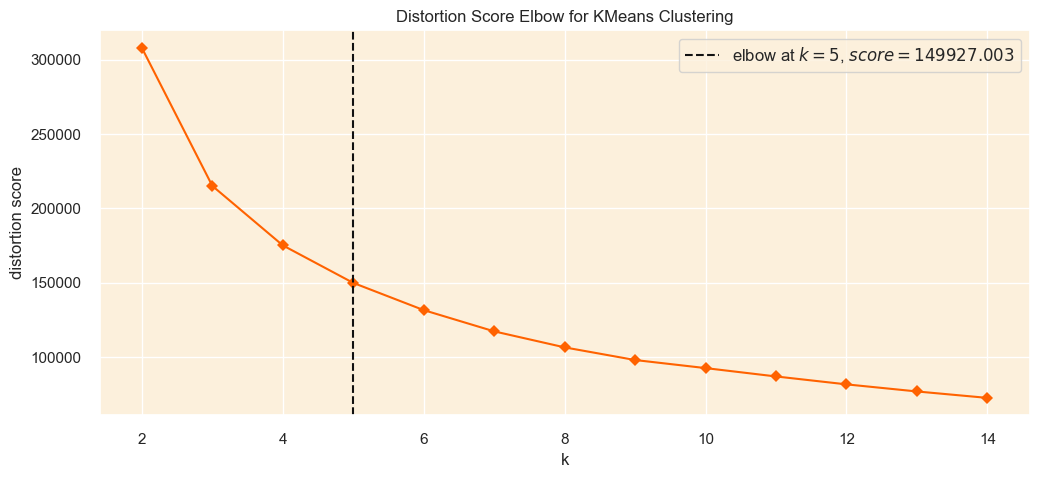

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [160]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show()

Considering both methods and the silhouette plot, since k=3 results in the most balanced clustering, we selected k=3 for customer segmentation

### Clustering

In [161]:
clusterer = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
cluster_labels = clusterer.fit_predict(customer_data_pca)

## DBSCAN
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a popular clustering algorithm that is primarily used to identify clusters of varying shapes and sizes in a dataset, while effectively handling noise and outliers.  

There are two major hyperparameters for DBSCAN:  
* min_samples: the minimum number of points required to form a dense region  
* eps: the radius of a neighborhood around a point  

To choose the optimal hyperparams, I still used silhouette scores and applied grid search.  
* For min_samples, choose MinPts = 2*dim (Sander et al., 1998)  
* After determining, min_samples, use sklearn NearestNeighbors and find the optimal value for eps at the point where the graph has the greatest slope (https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf)



### Hyperparameter Tuning

In [19]:
min_samples = np.arange(8,20) # min_samples values to be investigated
no_of_clusters = []
sil_score = []

for p in min_samples:
    DBS_clustering = DBSCAN(min_samples=p).fit(customer_data_pca)
    print(f'done dbs for min_samples={p}')
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(customer_data_pca, DBS_clustering.labels_))
    print(f'done silhouette for min_samples={p}')

print(sil_score)


done dbs for min_samples=8
done silhouette for min_samples=8
done dbs for min_samples=9
done silhouette for min_samples=9
done dbs for min_samples=10
done silhouette for min_samples=10
done dbs for min_samples=11
done silhouette for min_samples=11
done dbs for min_samples=12
done silhouette for min_samples=12
done dbs for min_samples=13
done silhouette for min_samples=13
done dbs for min_samples=14
done silhouette for min_samples=14
done dbs for min_samples=15
done silhouette for min_samples=15
done dbs for min_samples=16
done silhouette for min_samples=16
done dbs for min_samples=17
done silhouette for min_samples=17
done dbs for min_samples=18
done silhouette for min_samples=18
done dbs for min_samples=19
done silhouette for min_samples=19
[-0.009489853384687743, -0.006838292858965334, -0.0014159662778925194, 0.042729647300251875, 0.08375443649412295, 0.08155841350655721, 0.07860323502963336, 0.07736970791237523, 0.07620276330994492, 0.07518689929174915, 0.07385848241900356, 0.072884

The highest silhouette score came from min_samples = 12

In [23]:
neighbors = NearestNeighbors(n_neighbors=12)
neighbors_fit = neighbors.fit(customer_data_pca)
distances, indices = neighbors_fit.kneighbors(customer_data_pca)

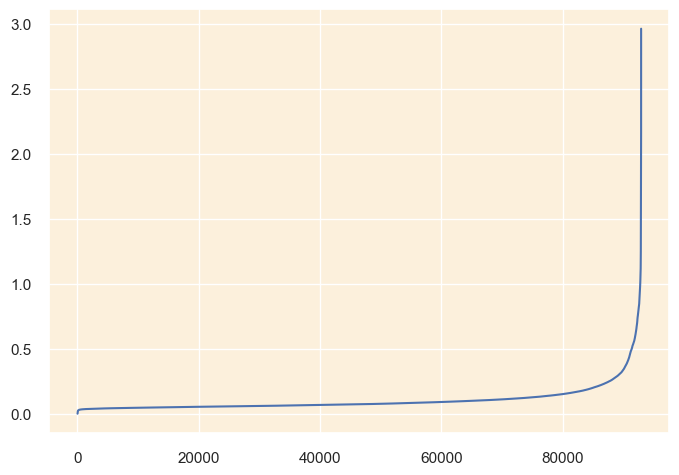

In [35]:
distances = np.sort(distances, axis=0)
distances = distances[:,-1]
plt.plot(distances)

Text(0, 0.5, 'Eps')

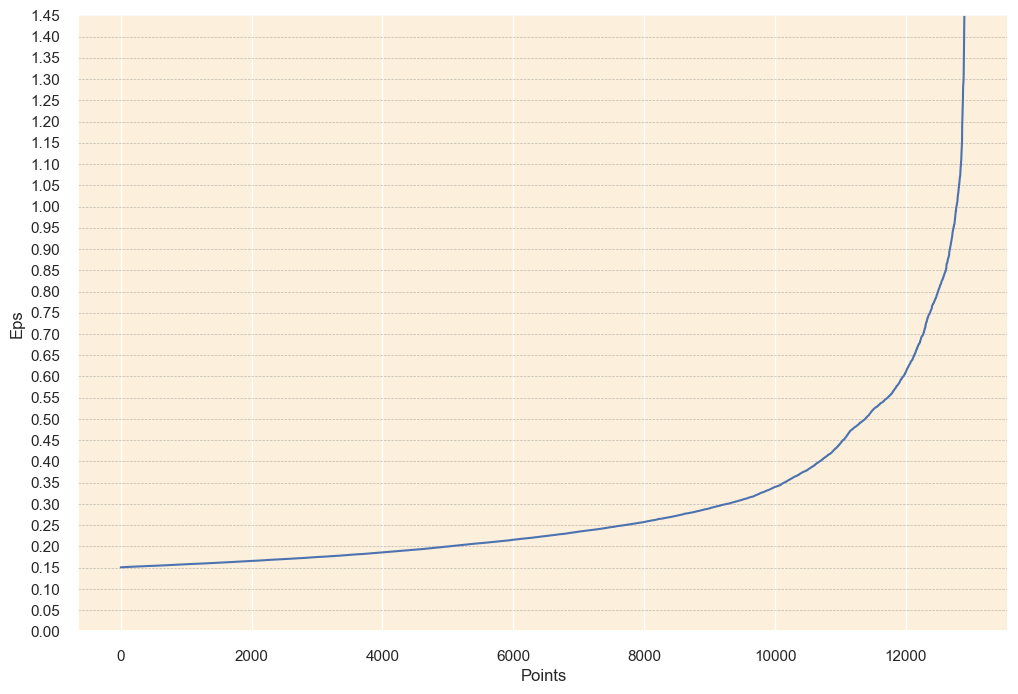

In [38]:
plt.figure(figsize=(12,8))

plt.ylim(0, 1)  # Set the lower limit to None (default) and upper limit to 0.5

# Add grid for y-axis
plt.grid(axis='y', linewidth=0.5, linestyle='--', color='gray', alpha=0.5)
plt.yticks([i for i in np.arange(0, 1.5, 0.05)])

plt.plot(distances[80000:])
plt.xlabel('Points')
plt.ylabel('Eps')

In [51]:
distances[80000:]

array([0.15090903, 0.15091015, 0.15091121, ..., 2.26846019, 2.4865529 ,
       2.96433972])

In [46]:
kneedle = KneeLocator(range(1,len(distances[80000:])+1),  #x values
                      distances[80000:], # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="increasing") #parameter from figure

In [48]:
print(kneedle.elbow)

12764


In [56]:
distances[kneedle.elbow+80000]

0.9905104945805809

The elbow point is 0.99, so the optimal eps could be set at 0.99

#### Summary: 
the optimal hyperparameter could be set as {min_samples: 12, eps: 0.99}

### Clustering

In [63]:
DBS_clustering = DBSCAN(eps=0.99, min_samples=12).fit(customer_data_pca)

print('Number of Clusters:', len(np.unique(DBS_clustering.labels_)))
print('Silhouette Score:', silhouette_score(customer_data_pca, DBS_clustering.labels_))


Number of Clusters: 2
Silhouette Score: 0.4784132779944284


In [64]:
DBSCAN_clustered = customer_data_pca.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,42
0,92880


Since the DBSCAN above only resulted in 2 clusters, with one of them being the outlier cluster (label=-1) and the normal points not separated, which means it is not insightful enough. I selected another point a bit lower than 0.99 to generate more than 2 clusters:

In [82]:
DBS_clustering = DBSCAN(eps=0.6, min_samples=12).fit(customer_data_pca)

print('Number of Clusters:', len(np.unique(DBS_clustering.labels_)))
print('Silhouette Score:', silhouette_score(customer_data_pca, DBS_clustering.labels_))


Number of Clusters: 5
Silhouette Score: 0.07423133741533854


In [83]:
DBSCAN_clustered = customer_data_pca.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,536
0,39679
1,52674
2,20
3,13


The average silhouette_score is : 0.07423133741533854


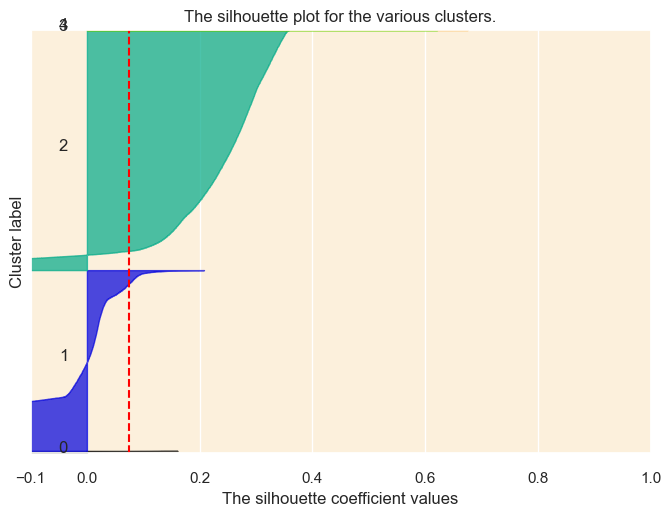

In [86]:
plt.xlim([-0.1, 1])
plt.ylim([0, len(customer_data_pca) + (5 + 1) * 10])

cluster_labels = DBS_clustering.labels_

# silhouette_avg = silhouette_score(customer_data_pca, cluster_labels)
print("The average silhouette_score is :", silhouette_avg)

# sample_silhouette_values = silhouette_samples(customer_data_pca, cluster_labels)

y_lower = 10

for i in range(5):

    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i-1]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 5)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10 for the 0 samples

plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

### Summary

From silhouette score and silhouette plot, we can see that DBSCAN does not perform so well as kmeans on our data, especially in terms of customer segmentation.  
Kmeans is much less expensive than DBSCAN for large dataset, and tends to produce clusters of roughly equal size, which is more helpful for customer segmentation. DBSCAN is valued more for its outlier detection function, and thus it is not so useful as kmeans in our case.  

Therefore, we used the kmeans clustering results for customer segmentation analysis.


# Customer Segmentation

In [162]:
customer_selected = customer_agg[['avg_review_score', 'rating_rate', 'comment_rate', 'n_payment_types', 
                                            'boleto', 'credit_card','debit_card', 'voucher', 
                                            'Beauty & Fashion', 'Electronics','Home & Living', 'Leisure & Entertainment', 'Tools',
                                            'Recency', 'Frequency', 'Monetary','average_payment_value']]

In [163]:
customer_selected['kmeans3'] = cluster_labels

In [164]:
customer_selected['kmeans3'].value_counts()

kmeans3
2    41844
0    34305
1    16773
Name: count, dtype: int64

pretty balanced clusters

In [165]:
customer_selected.to_csv('Generated_Dataset/customer4segment.csv', index=False)

## Descriptive Statistics Overview

In [166]:
customer_selected.groupby('kmeans3').mean()

,avg_review_score,rating_rate,comment_rate,n_payment_types,boleto,credit_card,debit_card,voucher,Beauty & Fashion,Electronics,Home & Living,Leisure & Entertainment,Tools,Recency,Frequency,Monetary,average_payment_value
kmeans3,,,,,,,,,,,,,,,,,
0,4.672710,0.999684,0.383712,1.017199,0.171529,0.801654,0.013642,0.013175,0.205555,0.198154,0.306046,0.196458,0.093786,278.157091,1.053870,282.269909,268.678089
1,1.628379,0.999766,0.700008,1.024563,0.196059,0.762719,0.013583,0.027638,0.185785,0.225118,0.348354,0.158344,0.082399,294.131104,1.027127,176.781124,169.928559
2,4.634783,0.999928,0.356363,1.033959,0.223200,0.720394,0.017832,0.038574,0.212787,0.234505,0.301767,0.166500,0.084441,289.757193,1.018904,66.088888,63.150857


## Radar Plot Visualization

In [167]:
cluster_centroids = customer_selected.groupby('kmeans3').mean()

Since different features have different scale, we use **Min-Max Scaling** to scale the data so that we can visualize the radar plot

In [169]:
scaler = MinMaxScaler()
cluster_centroids_scaled = scaler.fit_transform(cluster_centroids)

In [170]:
cluster_centroids_scaled_df = pd.DataFrame(cluster_centroids_scaled, columns=cluster_centroids.columns)
cluster_centroids_scaled_df

,avg_review_score,rating_rate,comment_rate,n_payment_types,boleto,credit_card,debit_card,voucher,Beauty & Fashion,Electronics,Home & Living,Leisure & Entertainment,Tools,Recency,Frequency,Monetary,average_payment_value
0,1.000000,0.000000,0.079583,0.000000,0.000000,1.000000,0.013884,0.000000,0.732174,0.000000,0.091851,1.000000,1.00000,0.000000,1.000000,1.000000,1.000000
1,0.000000,0.337093,1.000000,0.439396,0.474738,0.520865,0.000000,0.569441,0.000000,0.741773,1.000000,0.000000,0.00000,1.000000,0.235181,0.512035,0.519531
2,0.987542,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.213989,0.17931,0.726186,0.000000,0.000000,0.000000


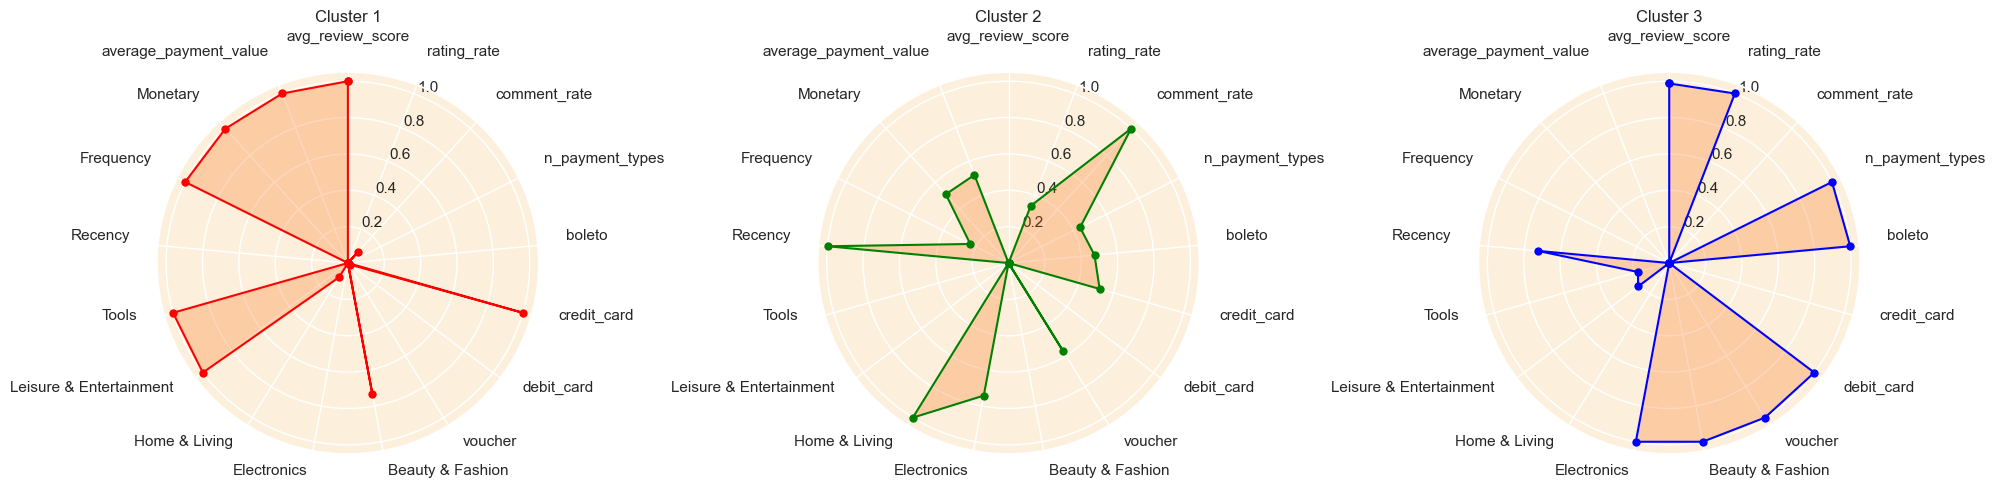

In [172]:
def make_radar_chart(ax, stats, attribute_labels=cluster_centroids.columns, plot_str='-',  color='b'):
    angles = np.linspace(0, 2 * np.pi, len(attribute_labels), endpoint=False).tolist()
    stats = np.concatenate((stats, [stats[0]]))  # Close the loop
    angles += angles[:1]  # Close the loop
    
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    ax.fill(angles, stats, alpha=0.25)
    ax.plot(angles, stats, plot_str, marker='o', color=color)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(attribute_labels)

    # adjust the location and direction of labels
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')

        label.set_verticalalignment('bottom')
        label.set_rotation(np.degrees(angle))
        label.set_rotation_mode('anchor')



fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 12), subplot_kw=dict(polar=True))

colors = ['red', 'green', 'blue', 'orange']

for i, ax in enumerate(axs.flatten()):
    make_radar_chart(ax, cluster_centroids_scaled[i], color=colors[i])
    ax.set_title(f'Cluster {i+1}')

plt.tight_layout()  
plt.show()

In [173]:
cluster_centroids_scaled_df

,avg_review_score,rating_rate,comment_rate,n_payment_types,boleto,credit_card,debit_card,voucher,Beauty & Fashion,Electronics,Home & Living,Leisure & Entertainment,Tools,Recency,Frequency,Monetary,average_payment_value
0,1.000000,0.000000,0.079583,0.000000,0.000000,1.000000,0.013884,0.000000,0.732174,0.000000,0.091851,1.000000,1.00000,0.000000,1.000000,1.000000,1.000000
1,0.000000,0.337093,1.000000,0.439396,0.474738,0.520865,0.000000,0.569441,0.000000,0.741773,1.000000,0.000000,0.00000,1.000000,0.235181,0.512035,0.519531
2,0.987542,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.213989,0.17931,0.726186,0.000000,0.000000,0.000000


In [185]:
cluster_centroids

,avg_review_score,rating_rate,comment_rate,n_payment_types,boleto,credit_card,debit_card,voucher,Beauty & Fashion,Electronics,Home & Living,Leisure & Entertainment,Tools,Recency,Frequency,Monetary,average_payment_value
kmeans3,,,,,,,,,,,,,,,,,
0,4.672710,0.999684,0.383712,1.017199,0.171529,0.801654,0.013642,0.013175,0.205555,0.198154,0.306046,0.196458,0.093786,278.157091,1.053870,282.269909,268.678089
1,1.628379,0.999766,0.700008,1.024563,0.196059,0.762719,0.013583,0.027638,0.185785,0.225118,0.348354,0.158344,0.082399,294.131104,1.027127,176.781124,169.928559
2,4.634783,0.999928,0.356363,1.033959,0.223200,0.720394,0.017832,0.038574,0.212787,0.234505,0.301767,0.166500,0.084441,289.757193,1.018904,66.088888,63.150857


### Summary
From both the unscaled and scaled data, we can see that several features are not very significant among clusters:  
rating rate, number of payment types, Recency and Frequency. That is because most of the customers rate their order and purchased only once.   

However, there are several significant features too, such as Monetary, average review score, comment rate, etc.  

In profiling the customers, we mainly focusing on the significant features, but also aid our analysis with others that are helpful.

## Profiling Product Category Groups By Price

In [181]:
customer_product.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_id,product_category_name,order_item_id,seller_id,shipping_limit_date,price,freight_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_creation_year,review_creation_month,review_creation_month_name,review_creation_year_month,product_category_name_english,product_category_group
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,87285b34884572647811a353c7ac498a,utilidades_domesticas,1.0,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",20171011.0,2017-10-12 03:43:48,2017.0,10.0,Oct,201710.0,housewares,Home & Living
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,595fac2a385ac33a80bd5114aec74eb8,perfumaria,1.0,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,20180808.0,2018-08-08 18:37:50,2018.0,8.0,Aug,201808.0,perfumery,Beauty & Fashion
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,aa4383b373c6aca5d8797843e5594415,automotivo,1.0,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,20180818.0,2018-08-22 19:07:58,2018.0,8.0,Aug,201808.0,auto,Tools
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,d0b61bfb1de832b15ba9d266ca96e5b0,pet_shop,1.0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,359d03e676b3c069f62cadba8dd3f6e8,5.0,NaN,O produto foi exatamente o que eu esperava e e...,20171203.0,2017-12-05 19:21:58,2017.0,12.0,Dec,201712.0,pet_shop,Beauty & Fashion
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,65266b2da20d04dbe00c5c2d3bb7859e,papelaria,1.0,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,e50934924e227544ba8246aeb3770dd4,5.0,NaN,NaN,20180217.0,2018-02-18 13:02:51,2018.0,2.0,Feb,201802.0,stationery,Tools


In [182]:
customer_product.groupby('product_category_group').agg({'price': 'mean'}).reset_index().rename(columns={'price': 'average_price'})

,product_category_group,average_price
0,Beauty & Fashion,119.841837
1,Electronics,134.143901
2,Home & Living,105.242259
3,Leisure & Entertainment,129.572055
4,Missing,113.564621
5,Tools,131.677600


### Summary
Electronics, Tools, Leisure & Entertainment: High-value items  
Beauty & Fashion: Mid-value items  
Home & Living: Low-value items

## Customer Profiling

### Statistical Summary
* Cluster 0:  
review behavior: High average review score, Low comment rate  
payment preference: loyal to credit card, low voucher --> low diversity, campaign unresponsive  
product preference: prefer Beauty&Fashion, Leisure&Entertainment and Tools--> high-value items  
RFM: Low Recency, High Frequency, High Monetary and High average_payment_value  

* Cluster 1:  
review behavior: Low average review score, High comment rate  
payment preference: both boleto and credit card, high use rate of voucher --> high diversity, campaign responsive   
product preference:  prefer Electronics and HomeLiving  
RFM: High Recency, Mid Frequency, Mid Monetary and Mid average_payment_value  

* Cluster 2:  
review behavior: High average review score, Low comment rate  
payment preference: most balanced and diverse payment method, high use rate of voucher --> high diversity, campaign responsive  
product preference: prefer Beauty&Fashion, Home&Living and Electronics  
RFM:  Mid Recency, Low Frequency, Low Monetary and Low average_payment_value


Since most of the customers in our data only purchased once, and we do not have enough data to get insight into the customer retention, we do not define each segments and marketing strategies using Recency and Frequency.

### Segmentation Insights and Marketing Strategies

Based on the Statistical Summay above, we can define the 3 segments and tailor marketing strategies for different customer segments:  

* **Cluster 0: Loyal, High-Value, but Low-Engagement Customers**:  
    * They have high frequency, and high average review score, denoting their loyalty and satisfaction;  
    * They are less responsive to marketing campaign, and have low comment rates, denoting low-engagement;  
    * They prefer high-value items, have high monetary values, denoting their high purchasing power.  
      

    🔍 **Marketing Strategies**:  
    * Enhance Relationship Marketing by Providing Value-Add Services:  
    Provide personalized value-added services and rewards for them, like loyalty membership, including exclusive offers and member-only events, to solidify the relationship and enhance satisfaction;  
    * Brand Advocates:      
    Encourage these customers to share their positive experiences through word of mouth and social media, and also implement referral programs that can reward customers for bringing in new customers  
      
      

* **Cluster 1: Engaged, Responsive, but Demanding Customers**:  
    * They have high comment rates and high campaign response rates, denoting their high-engagement;  
    * Despite their high comment rates, they have much lower average review scores, indicating that they are very demanding and even picky, hard to deal with;  
    * They are highly responsive to marketing compaigns, indicating that they are sensitive to price.  
        

    🔍 **Marketing Strategies**:  
    * Targeted promotions and discounts:  
    Offer them targeted marketing campaigns such as vouchers and discounts, using email and app for notification, to incentivize them to purchase;  
    * Enhance customer support and feedback loop:  
    Provide them with priority customer support, where their negative reviews and feedbacks can be answered and addressed frequently and respectfully.


* **Cluster 2: At-Risk but Opportunistic Customers**:  
    * They have low frequency, low monetary value, and low comment rate, but highly responsive to marketing campaigns  
    * These customers are more passive in purchasing on Olist, engaging primarily when there are incentives or promotions.  
    * However, their average review score is high, meaning that they are worth retaining due to their significant potential value opportunities.  
        
        
    🔍 **Marketing Strategies**:  
    * Personalized Re-engagement Campaigns:  
    Design personalized loyalty program to encourage engagement, such as subscription and membership rewards; and also intensify personalized emails or targeted ads to remind them of the benefits they can enjoy and introduce them to new offers tailored to their preferences.  
    * Targeted promotions and discounts:  
    Offer them targeted marketing campaigns such as vouchers and discounts to lure them back once they are detected at-risk.


# Classification Modeling

After clustering and segmentation, we have already generated the class labels for customers. At industry level, there are far more things to do besides merely analyzing the static data. Below is an overview of the process:  
1. Label customers based on their features using clustering and customer segmentation analytics;  
2. Build classification model that can categorize customers into segments rapidly;  
3. Collect and update database dynamically, engineer features in pipeline, and categorize customers using the classification model (instead of clustering fron the beginning);  
4. Monitor the model performance, and retrain the model based on new data  

That said, it's helpful if we can develop a classification model that can categorize customers based on their features.


In [190]:
customer_scaled_selected.head()

,avg_review_score,rating_rate,comment_rate,n_payment_types,boleto,credit_card,debit_card,voucher,Beauty & Fashion,Electronics,Home & Living,Leisure & Entertainment,Tools,Recency_log,Frequency,Monetary_log,average_payment_value_log
customer_unique_id,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,5.0,1.0,1.0,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.659346,1,0.287769,0.343176
0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,1.0,0.0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.629555,1,-1.731331,-1.667195
0000f46a3911fa3c0805444483337064,3.0,1.0,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.419743,1,-0.321063,-0.263024
0000f6ccb0745a6a4b88665a16c9f078,4.0,1.0,1.0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.680737,1,-1.153726,-1.092087
0004aac84e0df4da2b147fca70cf8255,5.0,1.0,0.0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.530494,1,0.688005,0.741683


In [191]:
customer_scaled_selected['Label'] = cluster_labels

In [ ]:
customer_scaled_selected.to_csv('Generated_Dataset/customer_4classify.csv', index=True)

In [3]:
# customer_scaled_selected = pd.read_csv('Generated_Dataset/customer_4classify.csv')
customer_scaled_selected.head()

,customer_unique_id,avg_review_score,rating_rate,comment_rate,n_payment_types,boleto,credit_card,debit_card,voucher,Beauty & Fashion,Electronics,Home & Living,Leisure & Entertainment,Tools,Recency_log,Frequency,Monetary_log,average_payment_value_log,Label
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,1.0,1.0,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.659346,1,0.287769,0.343176,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,1.0,0.0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.629555,1,-1.731331,-1.667195,2
2,0000f46a3911fa3c0805444483337064,3.0,1.0,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.419743,1,-0.321063,-0.263024,1
3,0000f6ccb0745a6a4b88665a16c9f078,4.0,1.0,1.0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.680737,1,-1.153726,-1.092087,2
4,0004aac84e0df4da2b147fca70cf8255,5.0,1.0,0.0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.530494,1,0.688005,0.741683,0


## Construct Training and Test Dataset

Actually, simply train the model based on the engineered dataset `customer_scaled_selected` would introduce **data leakage risk**, since all these features are time-related, and future data may be used in the training set if we conduct random train-test-split.  

An improved version would be we split the original e-commerce data into two by an exact time stamp, and conduct feature engineering, clustering, customer segmentation and labeling, all thos things independently on the two datasets, and eventually train our classification model on the former dataset and test it on the latter one.  

However, since most of the customers in our data only purchased once so that there is little leakage, we simply split our data randomly.

In [4]:
X = customer_scaled_selected.drop(columns=['Label', 'customer_unique_id'], axis=1)
y = customer_scaled_selected['Label']

In [6]:
y.value_counts()

Label
2    9931
0    8240
1    4049
Name: count, dtype: int64

Multi-classification, a bit imbalanced but not very high.  
Use **stratified split** to balanced the label in each set.

In [15]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [13]:
import logging
import lightgbm as lgb

logger = logging.getLogger('lightgbm')
logger.setLevel(logging.ERROR) 

## Single Train-Test-Split Score

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  # 20% of the data goes to the test set
    random_state=42,  # for reproducibility
    stratify=y  # ensure stratified splitting
)

# Check the distribution of labels in each set
print("Label distribution in the training set:")
print(pd.value_counts(y_train, normalize=True))  # Normalized distribution
print("\nLabel distribution in the test set:")
print(pd.value_counts(y_test, normalize=True))  # Normalized distribution

Label distribution in the training set:
Label
2    0.446951
0    0.370837
1    0.182212
Name: proportion, dtype: float64

Label distribution in the test set:
Label
2    0.446895
0    0.370837
1    0.182268
Name: proportion, dtype: float64


In [21]:
models = {
    "Random Forest": RandomForestClassifier(verbose=0, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbose=0, random_state=42),
    "LightGBM": LGBMClassifier(verbose=0, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print(f"{name} performance on the test set:")
    print(f"Accuracy: {accuracy:.5f}")
    print(f"Precision: {precision:.5f}")
    print(f"Recall: {recall:.5f}")
    print(f"F1 Score: {f1:.5f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\n")

Random Forest performance on the test set:
Accuracy: 0.99415
Precision: 0.99471
Recall: 0.99429
F1 Score: 0.99449
Confusion Matrix:
[[1630    3   15]
 [   1  807    2]
 [   5    0 1981]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1648
           1       1.00      1.00      1.00       810
           2       0.99      1.00      0.99      1986

    accuracy                           0.99      4444
   macro avg       0.99      0.99      0.99      4444
weighted avg       0.99      0.99      0.99      4444



XGBoost performance on the test set:
Accuracy: 0.99482
Precision: 0.99485
Recall: 0.99472
F1 Score: 0.99478
Confusion Matrix:
[[1635    4    9]
 [   3  806    1]
 [   6    0 1980]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1648
           1       1.00      1.00      1.00       810
           2       0.99      1.00      1

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


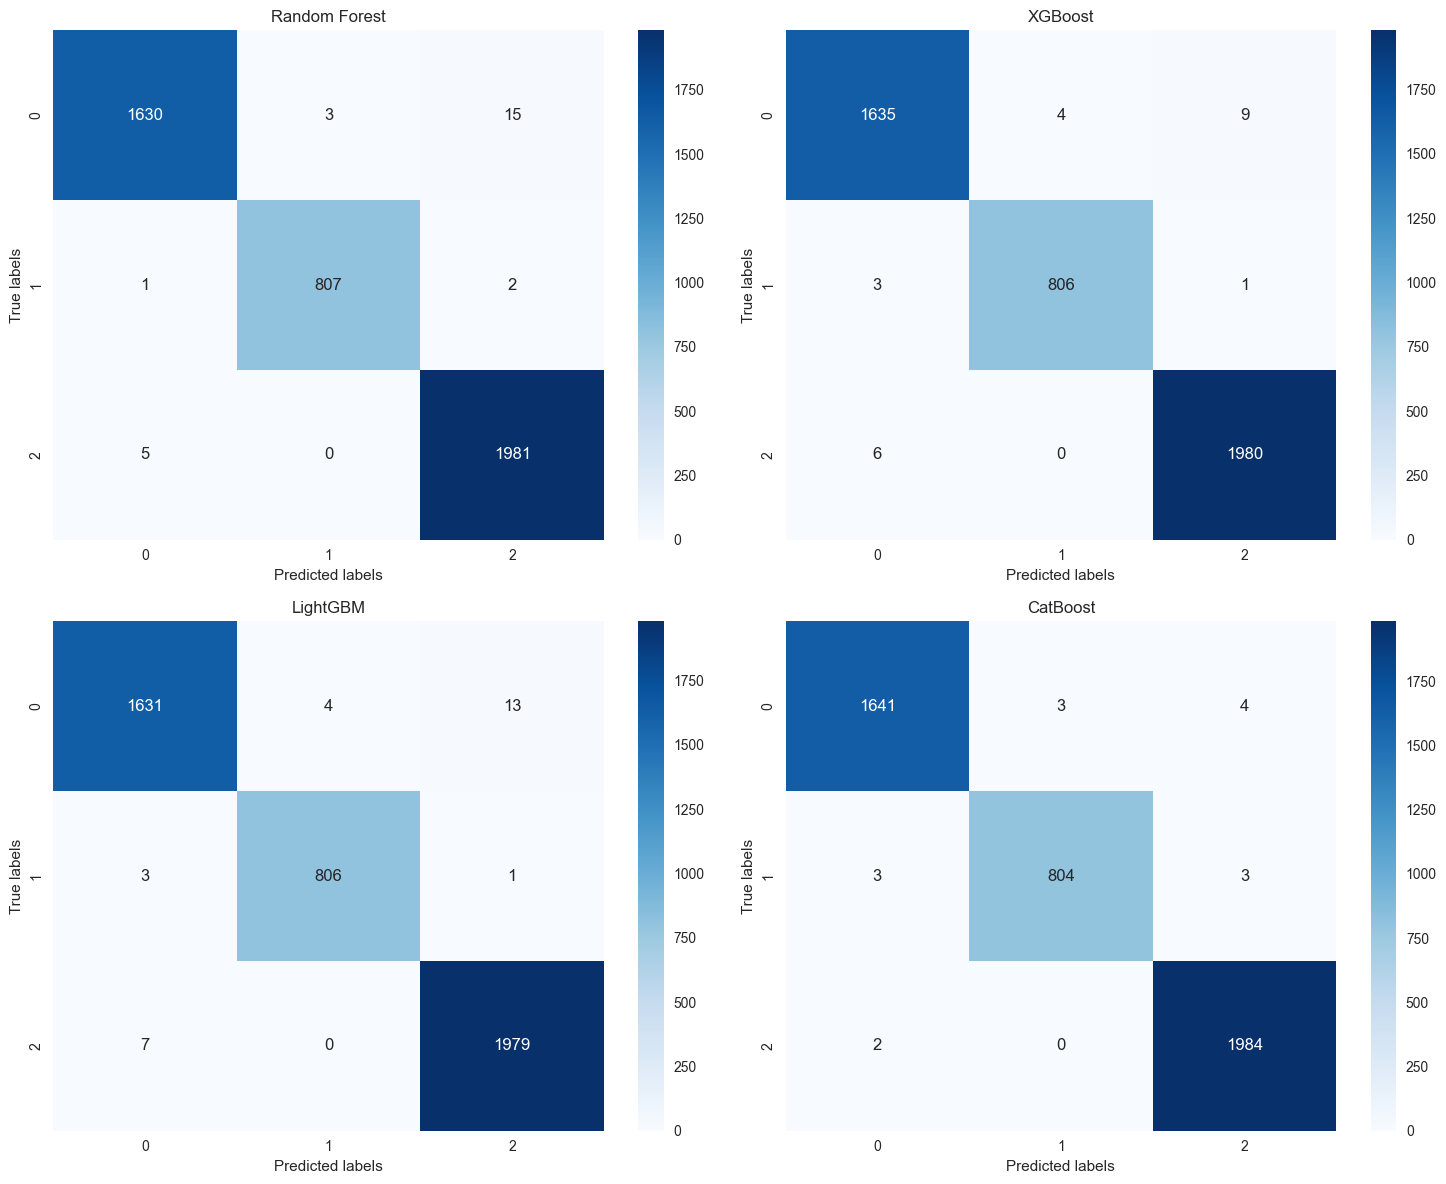

In [22]:
## Visualize Confusion Matrix

plt.figure(figsize=(15, 12))
for i, (name, model) in enumerate(models.items(), 1):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.subplot(2, 2, i)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(name)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

plt.tight_layout()
plt.show()


## Cross-Validation Score

In [20]:
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=8888)

rf_model = RandomForestClassifier(verbose=0, random_state=42)
rf_scores = cross_val_score(rf_model, X, y, cv=kfold)
print("Random Forest average accuracy:", np.mean(rf_scores))

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbose=0, random_state=42)
xgb_scores = cross_val_score(xgb_model, X, y, cv=kfold)
print("XGBoost average accuracy:", np.mean(xgb_scores))

# LightGBM
lgbm_model = LGBMClassifier(verbose=0, random_state=42)
lgbm_scores = cross_val_score(lgbm_model, X, y, cv=kfold)
print("LightGBM average accuracy:", np.mean(lgbm_scores))

# CatBoost
cat_model = CatBoostClassifier(verbose=0, random_state=42) 
cat_scores = cross_val_score(cat_model, X, y, cv=kfold)
print("CatBoost average accuracy:", np.mean(cat_scores))

Random Forest average accuracy: 0.9936543654365437
XGBoost average accuracy: 0.994824482448245
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM average accuracy: 0.9941494149414941
CatBoost average accuracy: 0.9955445544554454


## Feature Importance

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


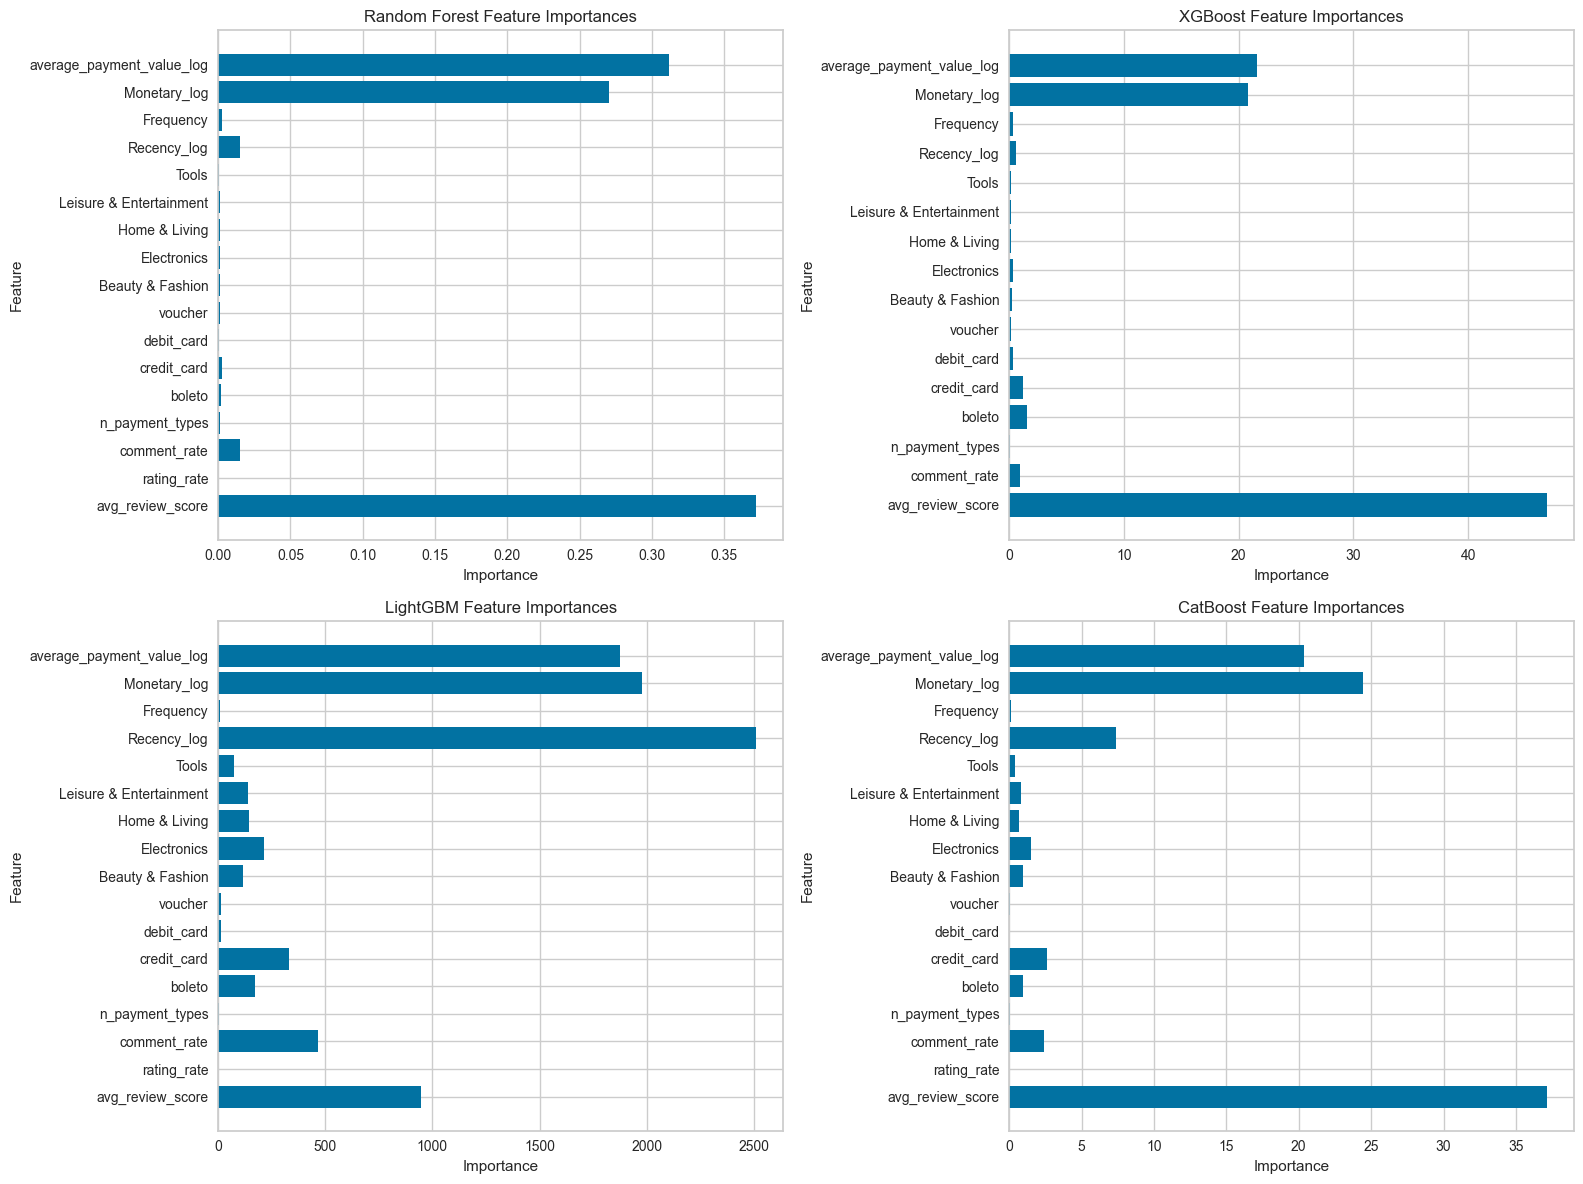

In [42]:
# Compare Difference of Models in Feature Importance

models = {
    "Random Forest": RandomForestClassifier(verbose=0, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbose=0, random_state=42),
    "LightGBM": LGBMClassifier(verbose=0, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

feature_names = list(X.columns)

feature_importances = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    if name == "XGBoost":
        booster = model.get_booster()
        importance_dict = booster.get_score(importance_type='gain')
        feature_importances[name] = list(importance_dict.items())
    elif hasattr(model, 'feature_importances_'):  ## lightgbm, random forest
        feature_importances[name] = list(zip(feature_names, model.feature_importances_))
    else:  ## catboost
        feature_importances[name] = list(zip(feature_names, model.get_feature_importance()))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, (name, importance) in enumerate(feature_importances.items()):
    # importance.sort(key=lambda x: x[1], reverse=True)
    features, importances = zip(*importance)
    axes[i].barh(features, importances)
    axes[i].set_title(f'{name} Feature Importances')
    axes[i].set_xlabel('Importance')
    axes[i].set_ylabel('Feature')

plt.tight_layout()
plt.show()

Why different?  
* The feature importance in Random Forest is primarily determined by Gini impurity at its splits across all trees in the forest. Specifically, it calculates the average reduction in impurity that occurs due to splits over a given feature.  
* XGBoost’s feature importance is computed by 'Gain', which represents the average gain of the splits where the feature was used, calculated by the change of gradient and hessian of the objective function.  
* Lightgbm's feature importance is the same as XGBoost, but here we used the default for lightgbm, which is the frequency of features that counts the number of times a feature is used to split the data across all trees.  
* CatBoost calculates feature importance by measuring the Permutation Feature Importance during model training, which is done by assessing how model performance varies with the exclusion of a feature.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


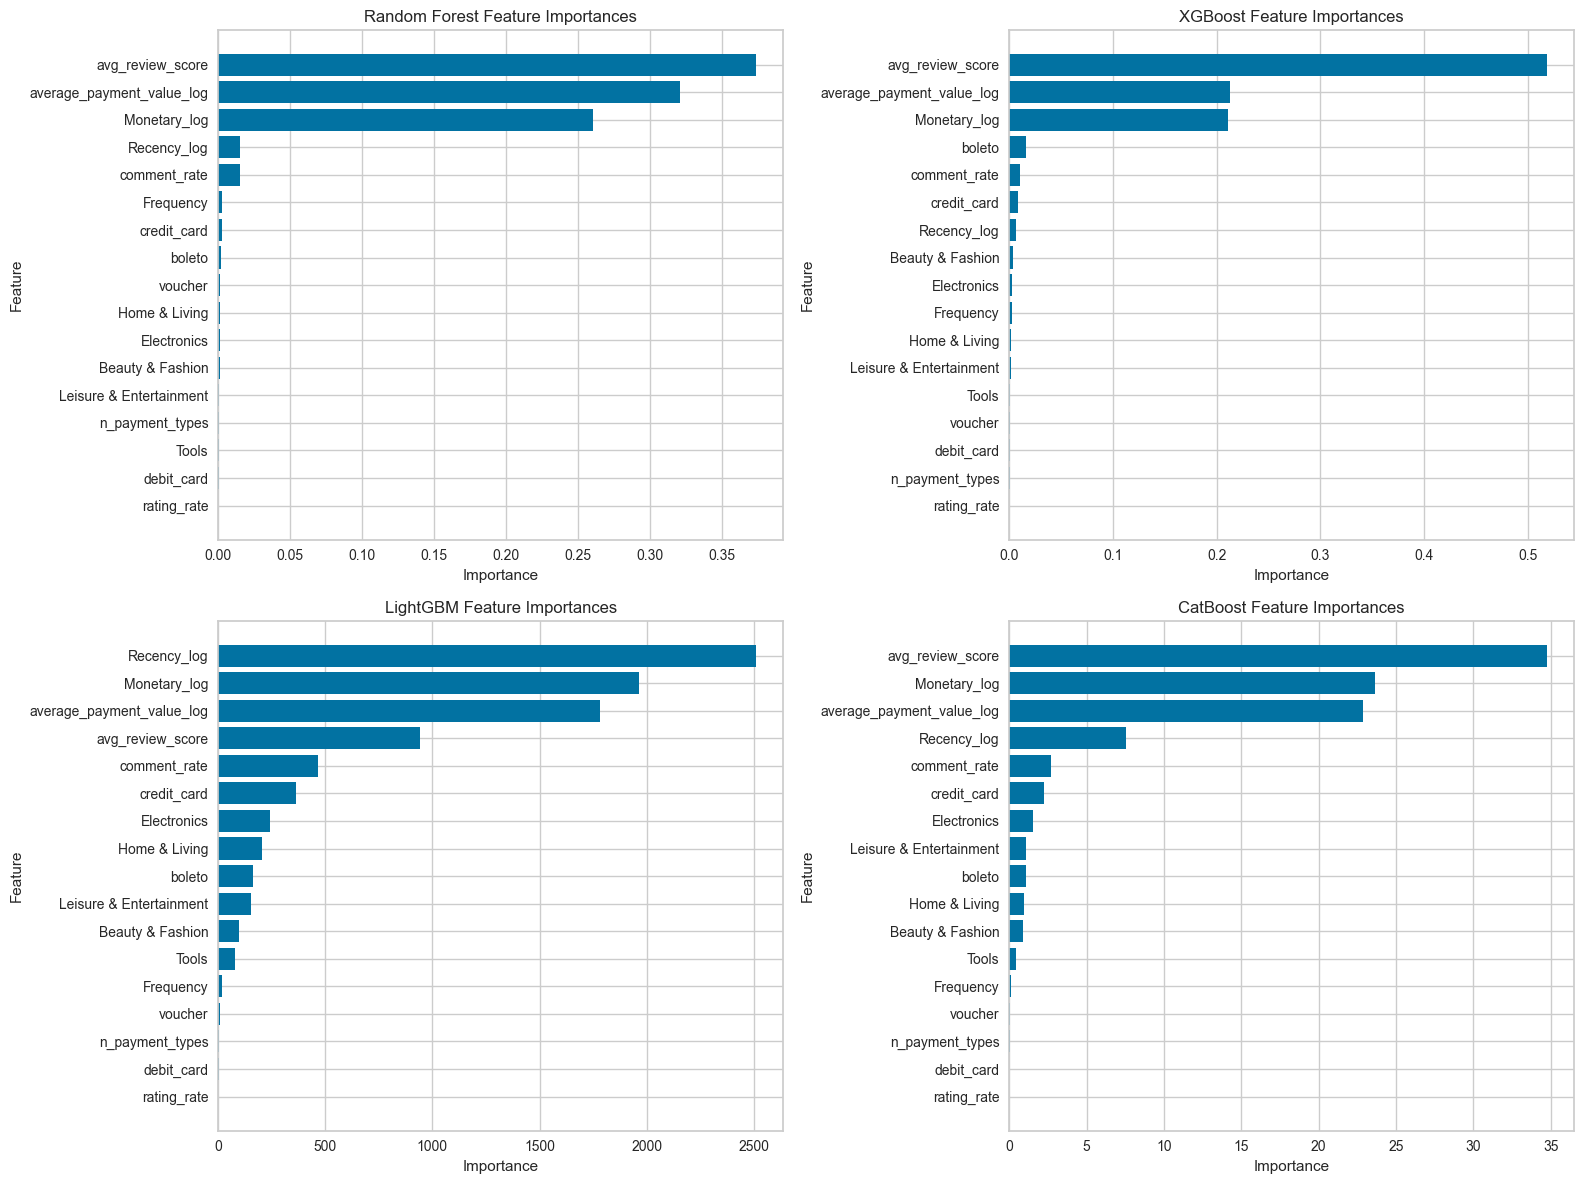

In [28]:
# Sort Features in The Order of Importance

models = {
    "Random Forest": RandomForestClassifier(verbose=0, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbose=0, random_state=42),
    "LightGBM": LGBMClassifier(verbose=0, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

feature_names = list(X.columns)

feature_importances = {}
for name, model in models.items():
    model.fit(X, y)
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:
        importance = model.get_feature_importance()

    features_sorted = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=False)
    feature_importances[name] = features_sorted

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, (name, features) in enumerate(feature_importances.items()):
    features, importances = zip(*features)
    axes[i].barh(features, importances)
    axes[i].set_title(f'{name} Feature Importances')
    axes[i].set_xlabel('Importance')
    axes[i].set_ylabel('Feature')

plt.tight_layout()
plt.show()

## Summary

* The classification models all achieved very high performance in predicting customer segments, with all classification metrics reaching more than 99%. That is because the labels for classification are generated by clustering the data using the same features. It may not be convincing, but represents our idea of speeding our customer categorization at industry level.  
* However, the feature importance generated by the ensemble-tree models could share important insights on feature selection. From the feature importance plot, we can see that the average review score and monetary are always listed at the top, indicating their importance in not only prediction, but also the previous customer segmentation. Rating rate, number of payment types and frequency do not count very much, because most of the customers share similar preference in terms of these features.  